# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import random
# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Rozwiązanie

Dostosuj aplikację graficzną tak, aby można było zadawać proste wielokąty przy użyciu
myszki, z dodatkowym zapisem i odczytem podanych wielokątów. Wielokąty powinny
być zadawane w kierunku przeciwnym do ruchu wskazówek zegara

In [3]:
def save_plot(plot):
    with open('save.json', 'w') as file:
        file.write(plot.toJson())
def get_plot(file_name):
    #Funkcja zwraca Plot, należy go jeszcze odtworzyć .draw()
    with open(file_name, 'r') as file:
        json = file.read()
    return Plot(json = json)
    

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


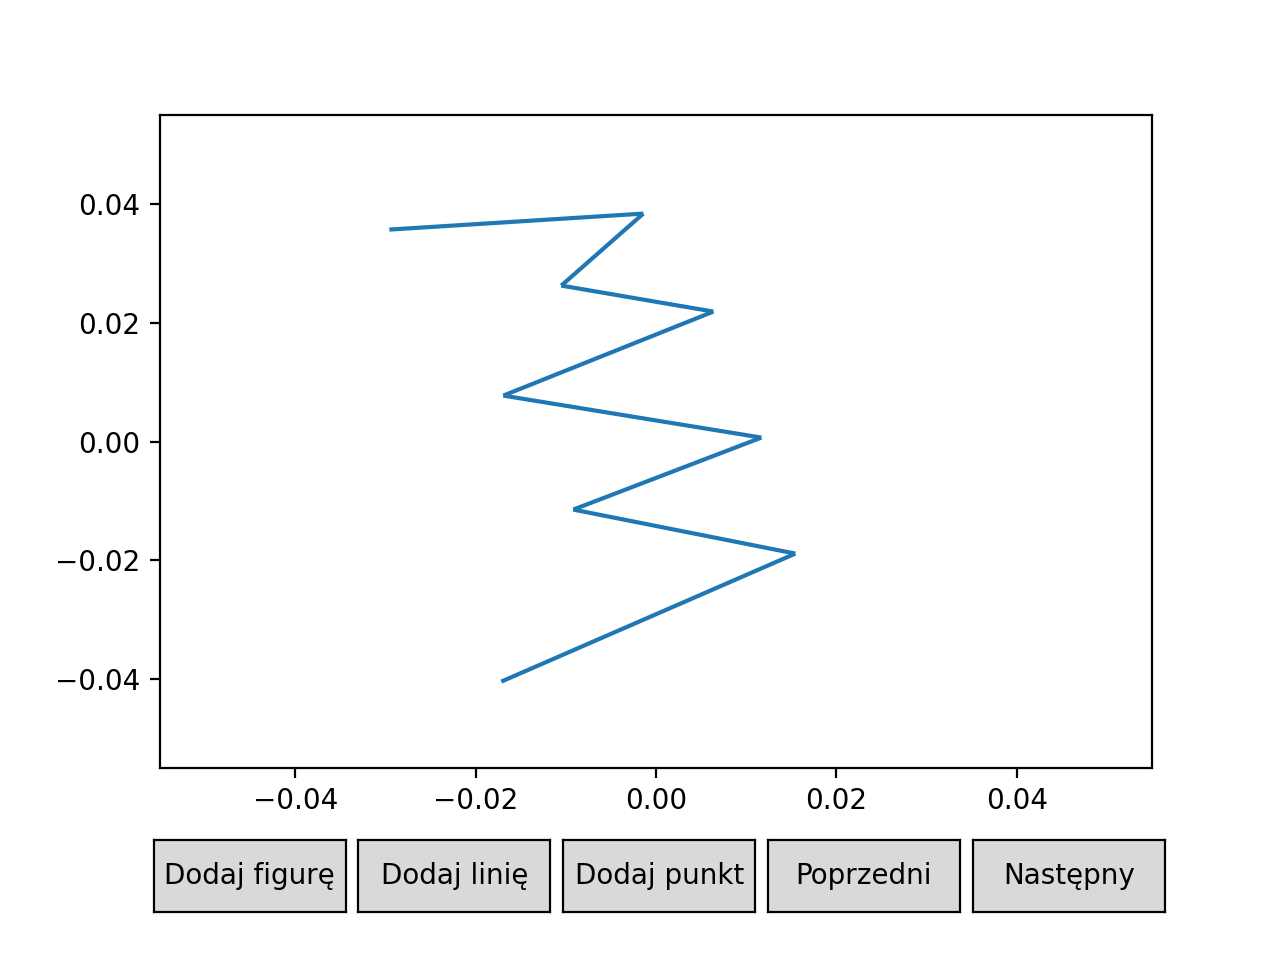

In [25]:
plot = Plot()    
plot.draw()

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


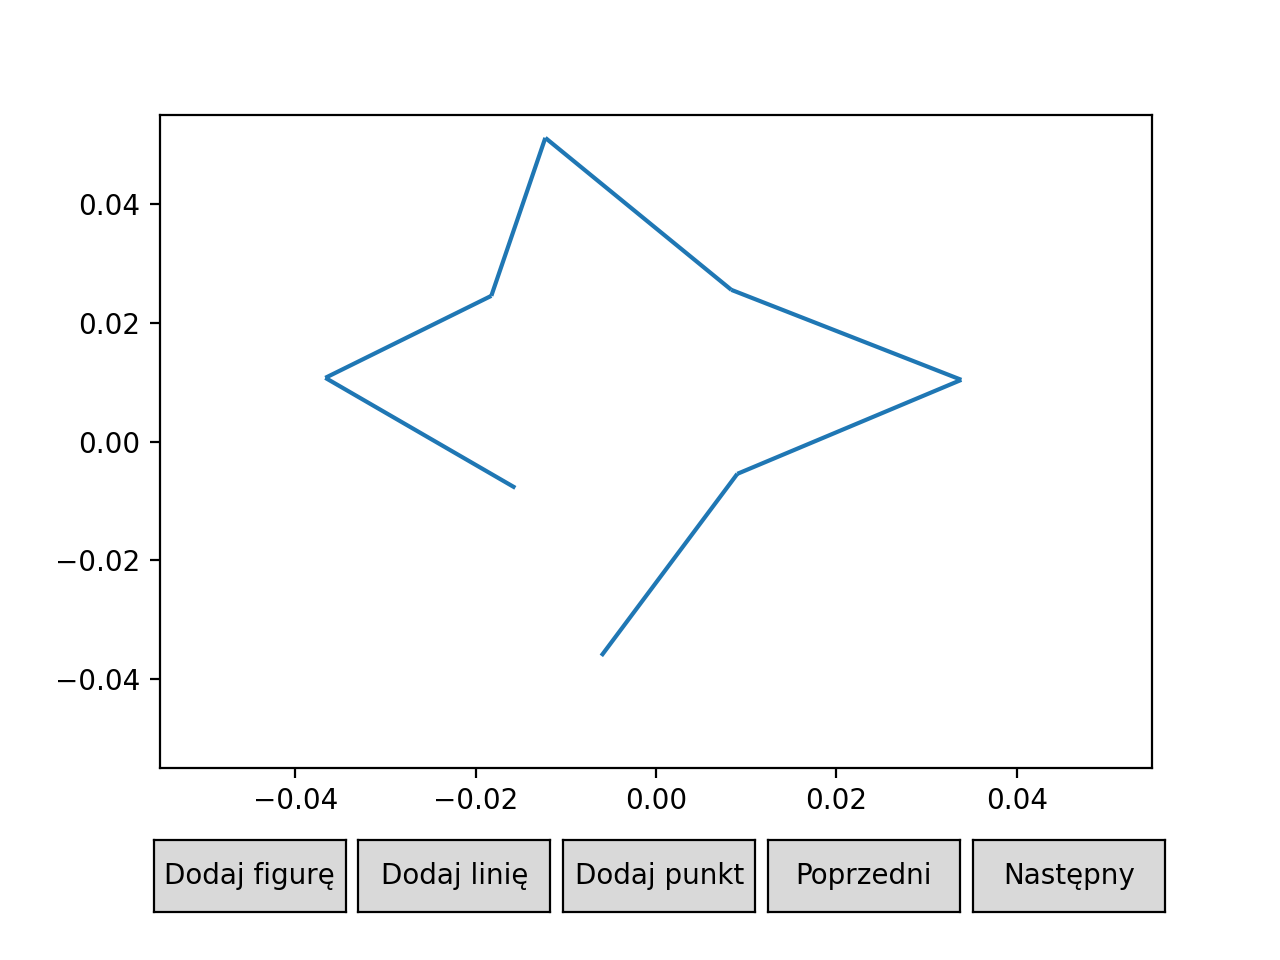

In [5]:
plot2 = Plot()    
plot2.draw()

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


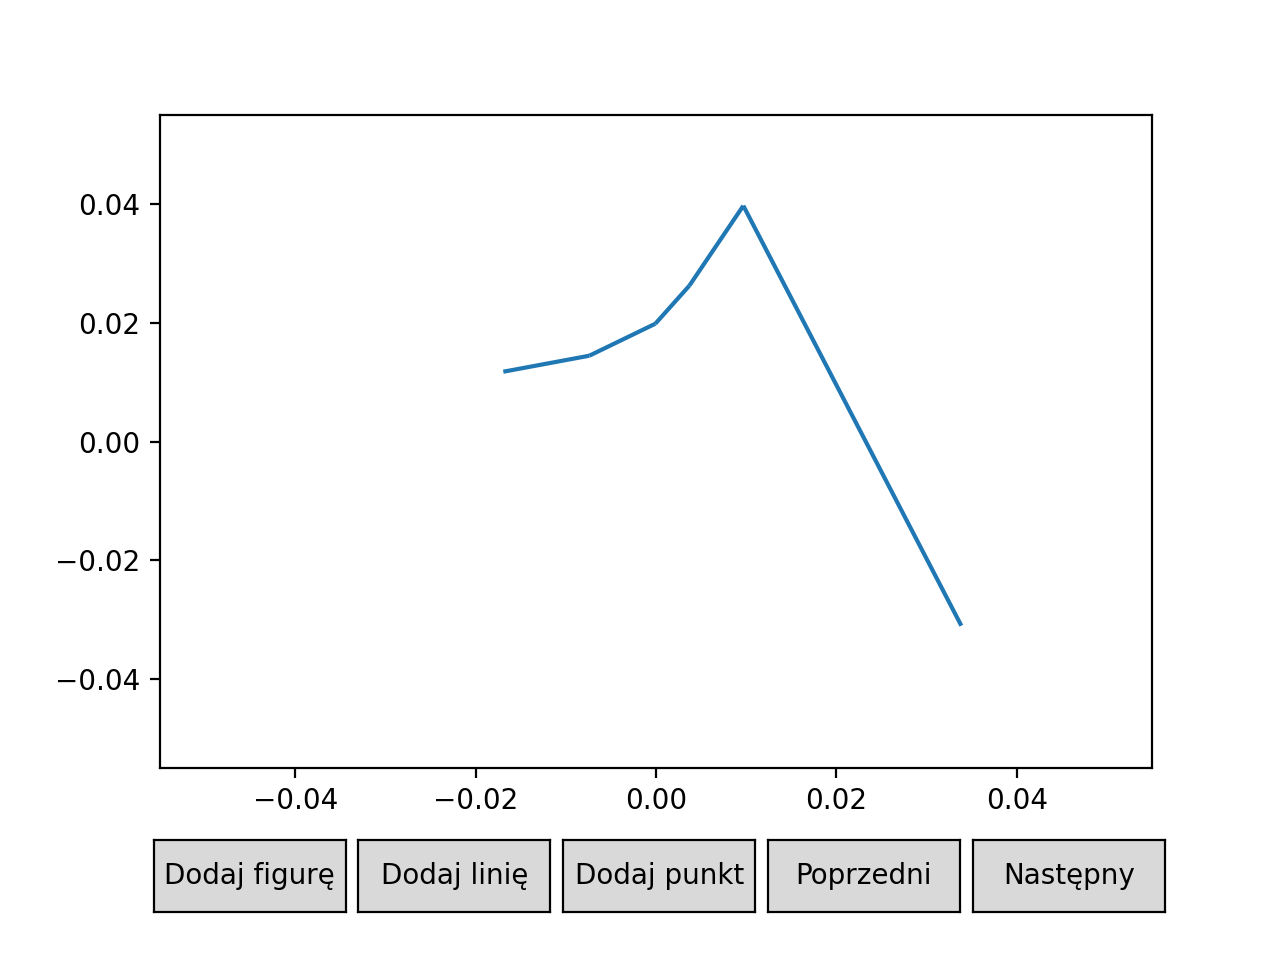

In [6]:
plot3 = Plot()    
plot3.draw()

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


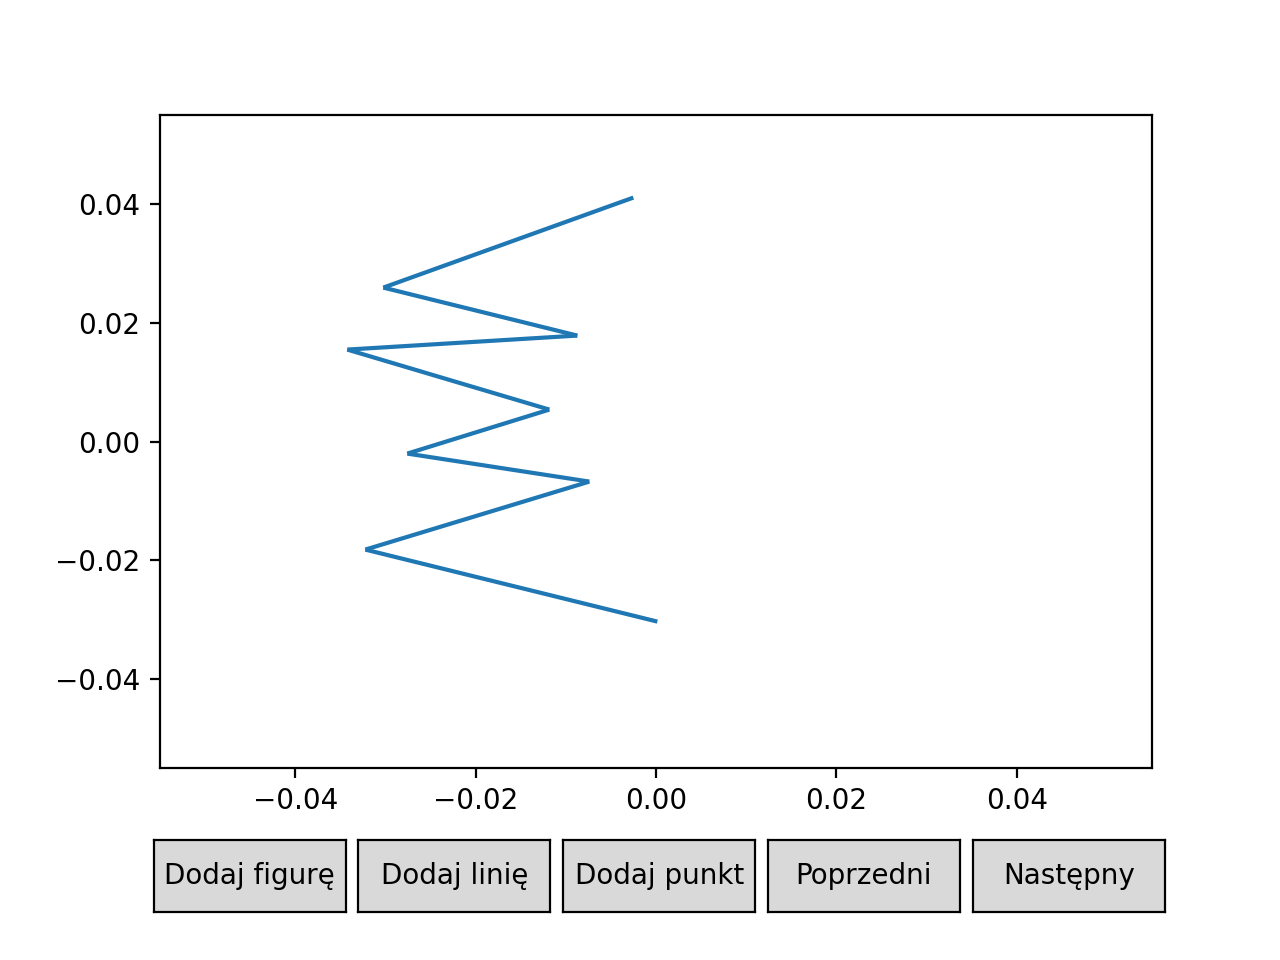

In [7]:
plot4 = Plot()    
plot4.draw()

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


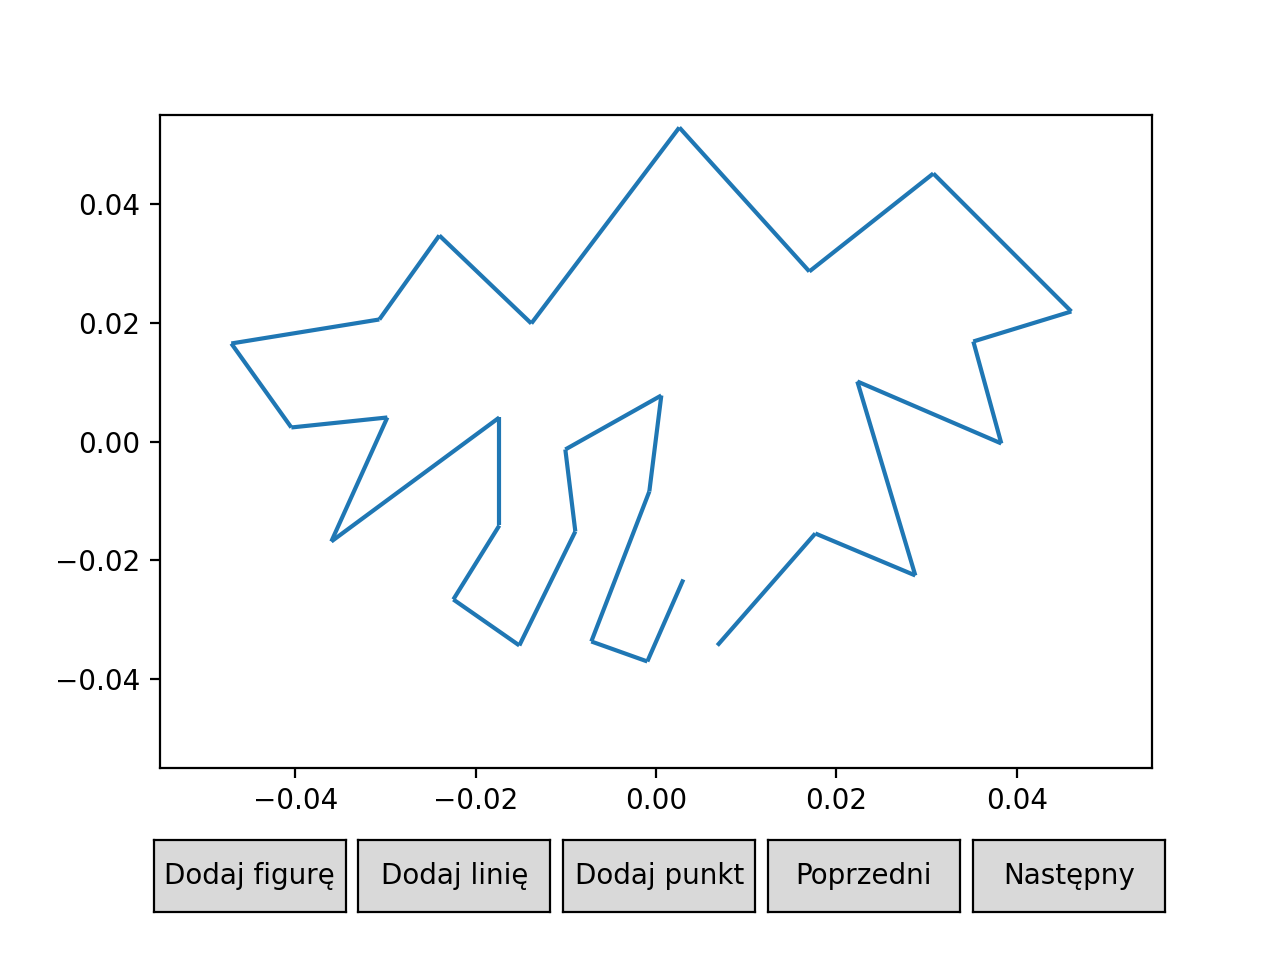

In [8]:
plot5 = Plot()    
plot5.draw()

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


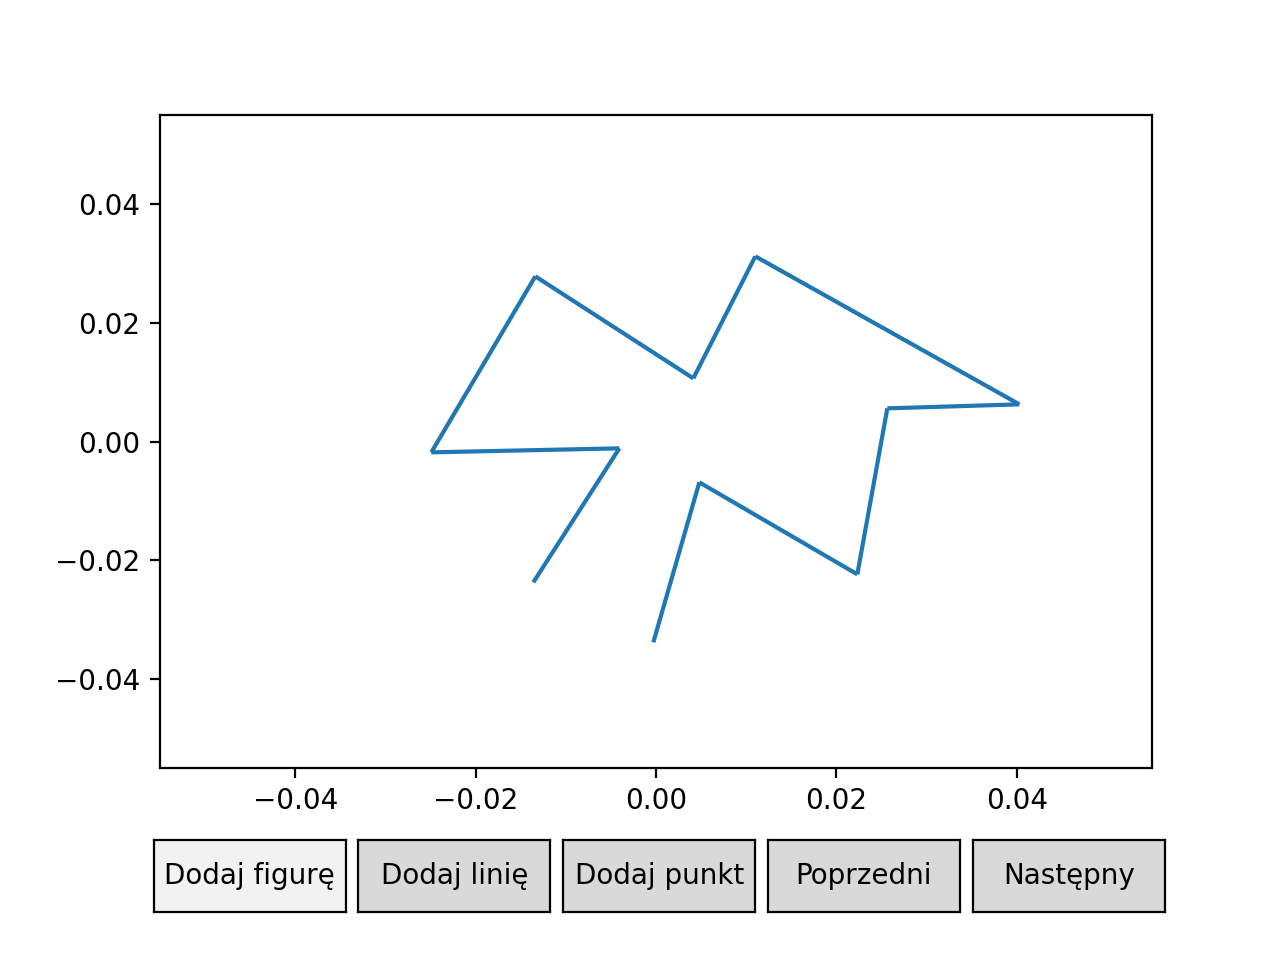

In [9]:
plot6 = Plot()    
plot6.draw()

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


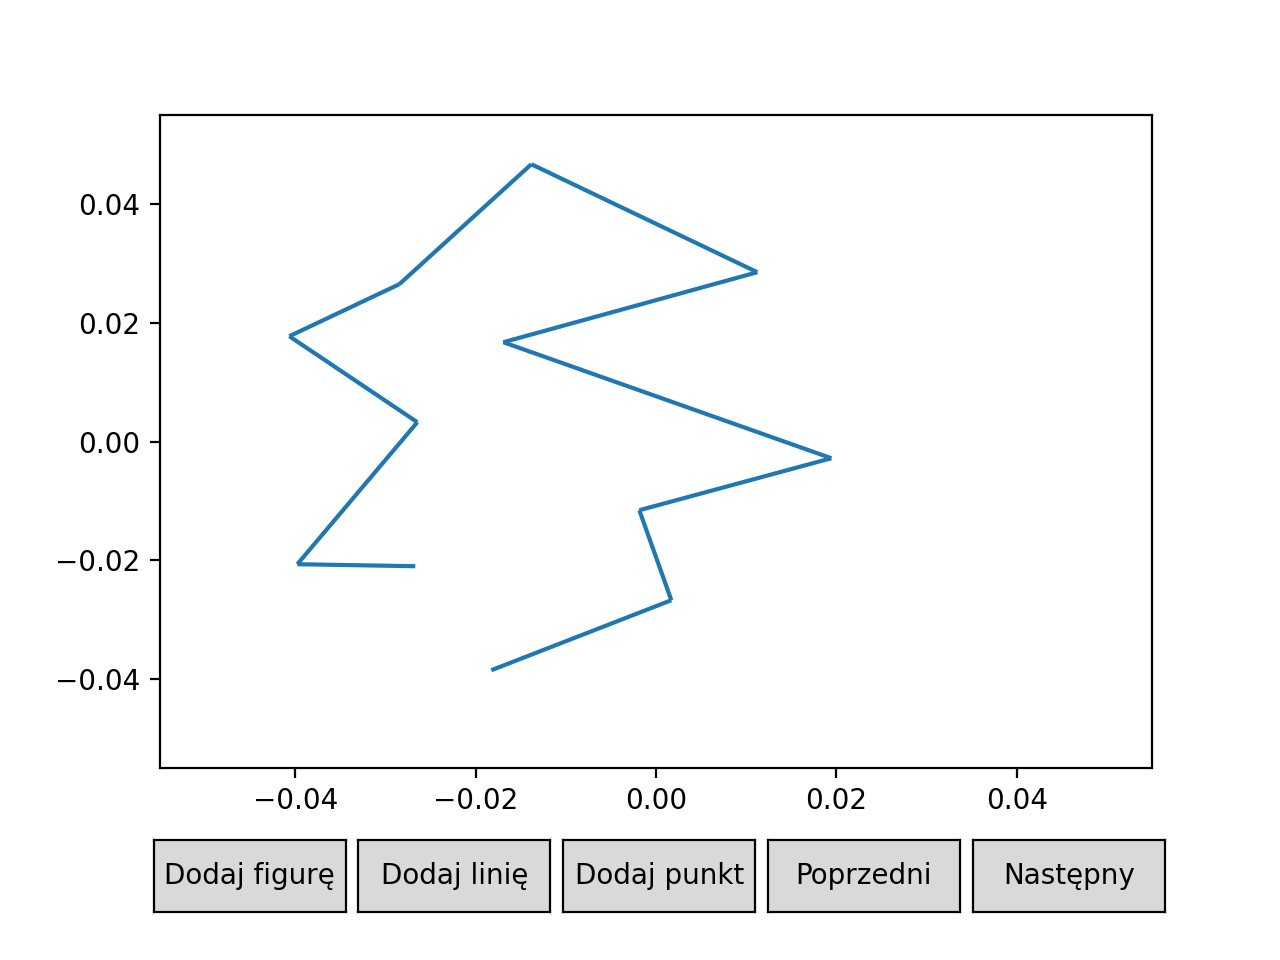

In [10]:
plot7 = Plot()    
plot7.draw()

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


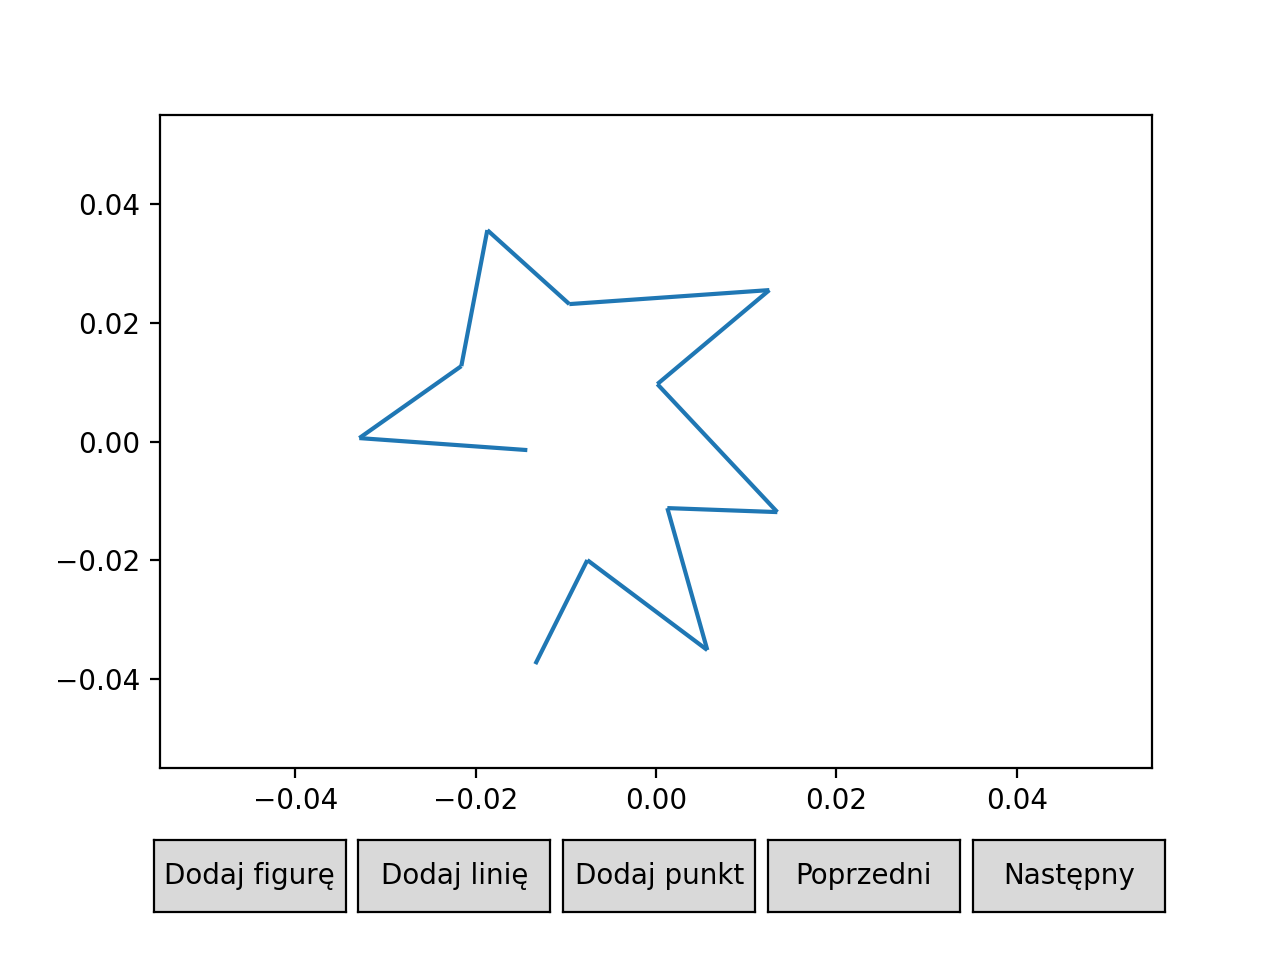

In [11]:
plot8 = Plot()    
plot8.draw()

In [21]:
def det(a,b,c):
    deta = a[0]*b[1] + b[0]*c[1] + a[1]*c[0]
    detb = c[0]*b[1] + c[1]*a[0] + b[0]*a[1]
    det = deta-detb
    return det
def get_points(plot):
    points = []
    lines = plot.get_added_figure()[0].lines
    for p in lines:
        points.append(p[0])
    points.append(lines[len(lines)-1][1])
    return points
def opposite_to_clock(a,b,c):
    det_points = det(a,b,c)
    if (det_points > 10**-12):
        return False
    if (a[1] < b[1] < c[1]):
        return False
    elif(a[1] > b[1] > c[1]):
        return False
    return True

Zaimplementuj procedurę sprawdzającą, czy podany wielokąt jest y-monotoniczny.

In [22]:
def y_monotoniczne(points):
    for i in range(0,len(points)-1):
        if opposite_to_clock(points[i-1],points[i],points[i+1]):
            return False
    if opposite_to_clock(points[len(points)-2],points[len(points)-1],points[0]):
        return False
    return True


In [23]:
def to_lines(points):
    lines = []
    for p in range(len(points)-1):
        lines.append([points[p], points[p+1]])
    lines.append([points[-1], points[0]])
    return lines

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


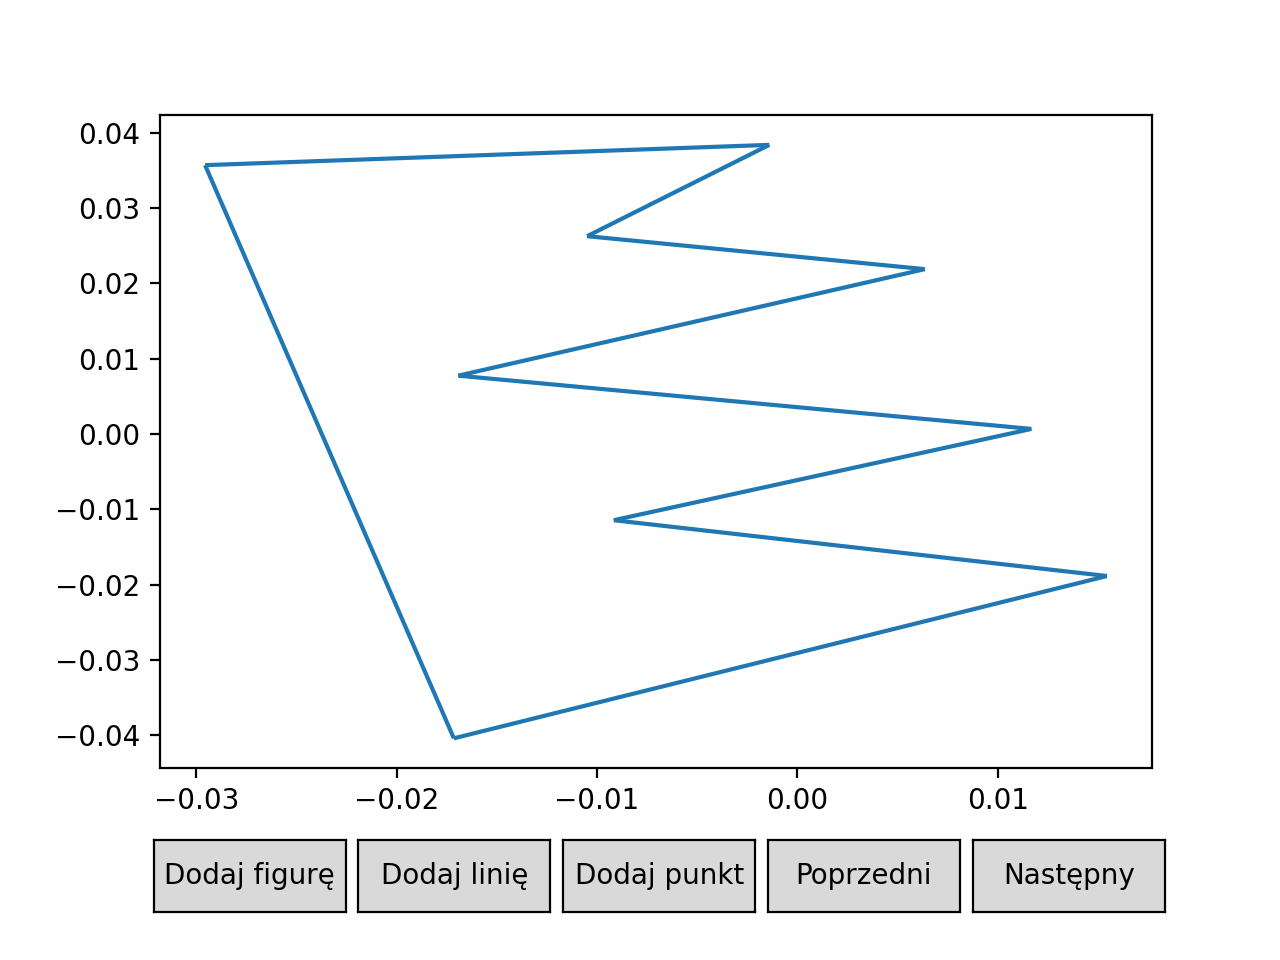

True

In [26]:
points = get_points(plot)
lines = to_lines(points)
Plot([Scene(lines=[LinesCollection(lines)])]).draw()
y_monotoniczne(points)

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


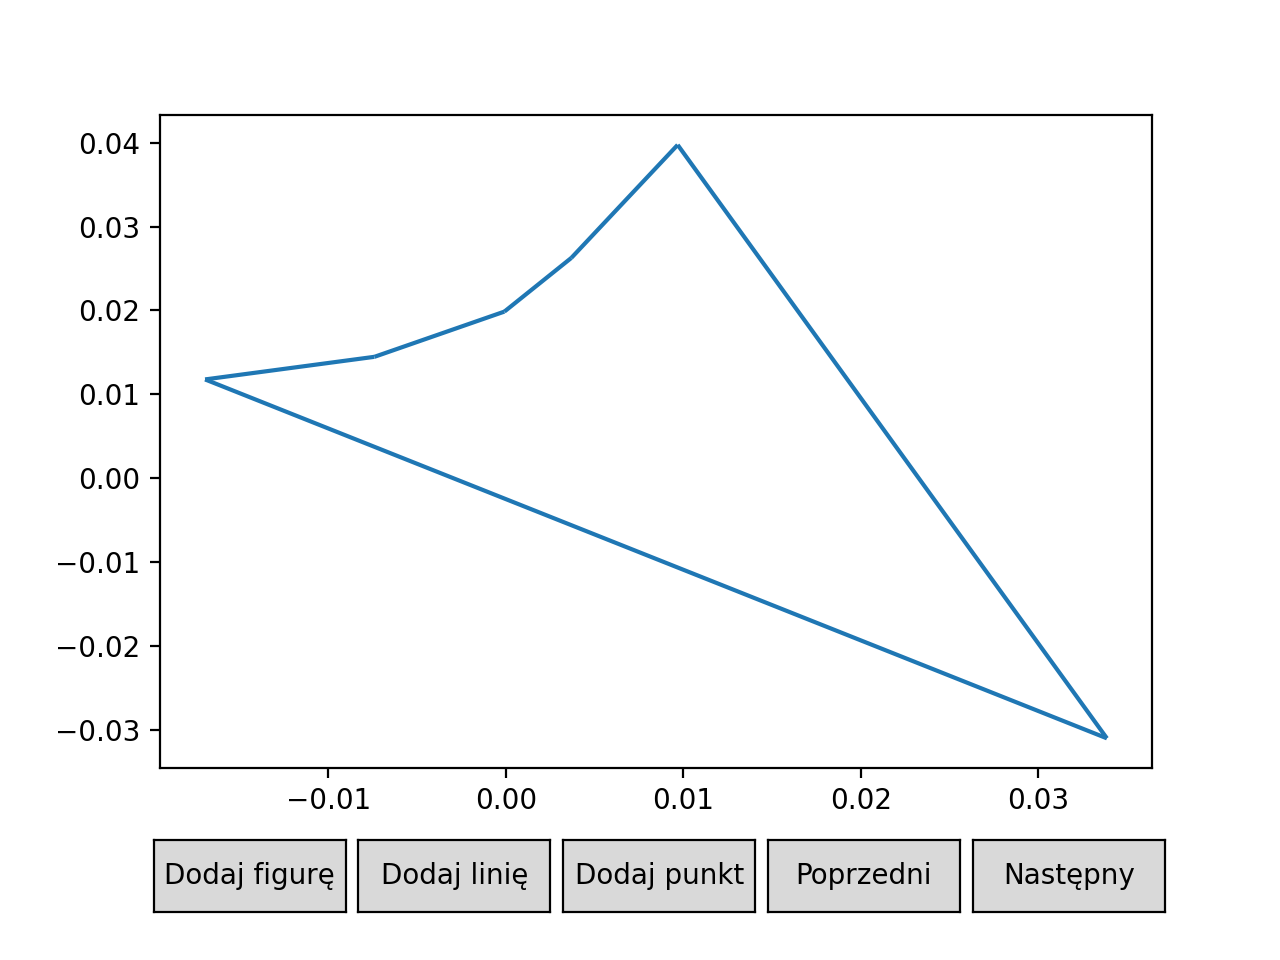

True

In [27]:
points3 = get_points(plot3)
lines3 = to_lines(points3)
Plot([Scene(lines=[LinesCollection(lines3)])]).draw()
y_monotoniczne(points3)

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


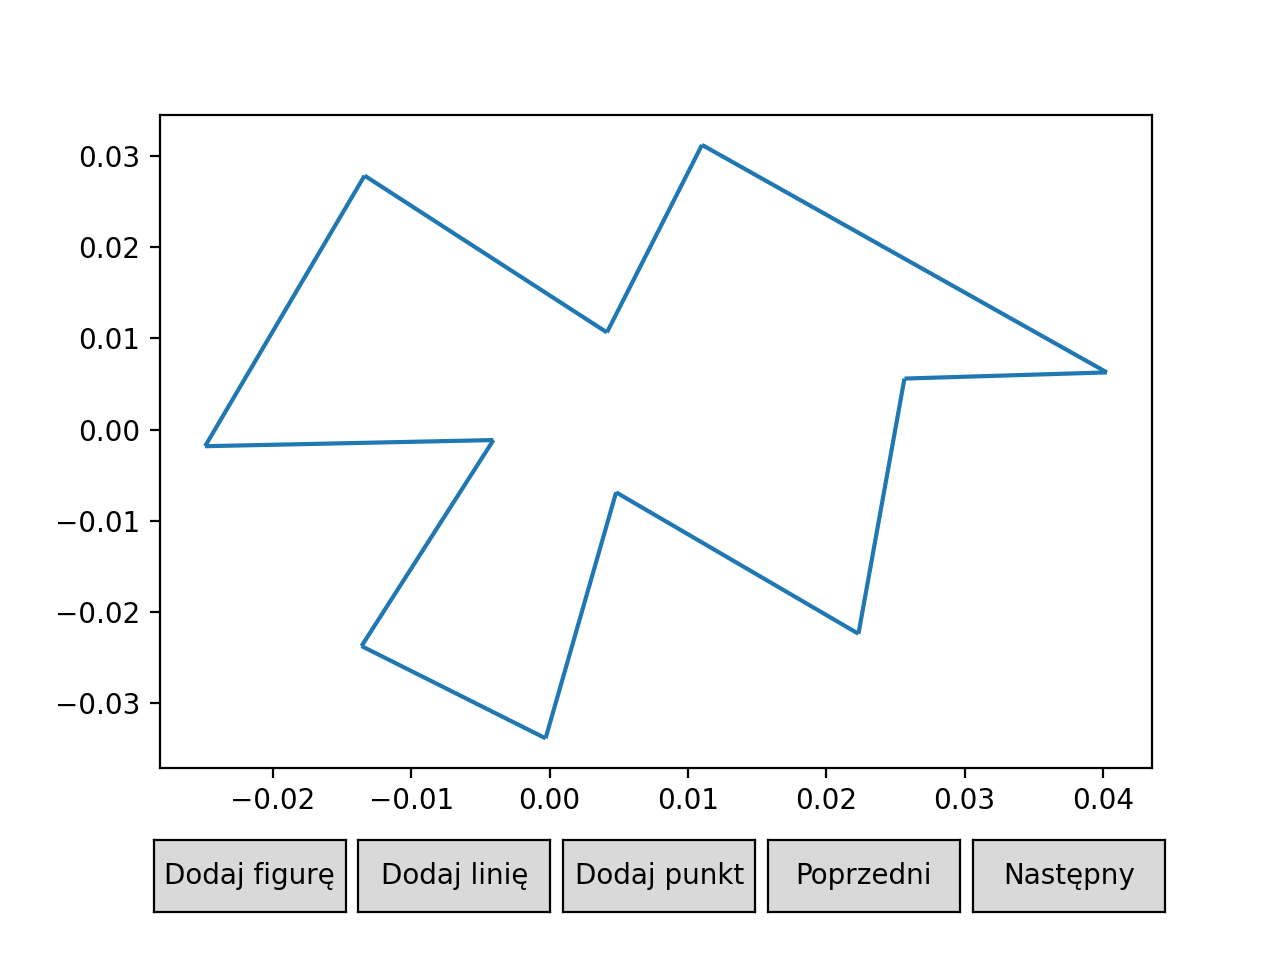

False

In [28]:
points6 = get_points(plot6)
lines6 = to_lines(points6)
Plot([Scene(lines=[LinesCollection(lines6)])]).draw()
y_monotoniczne(points6)

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


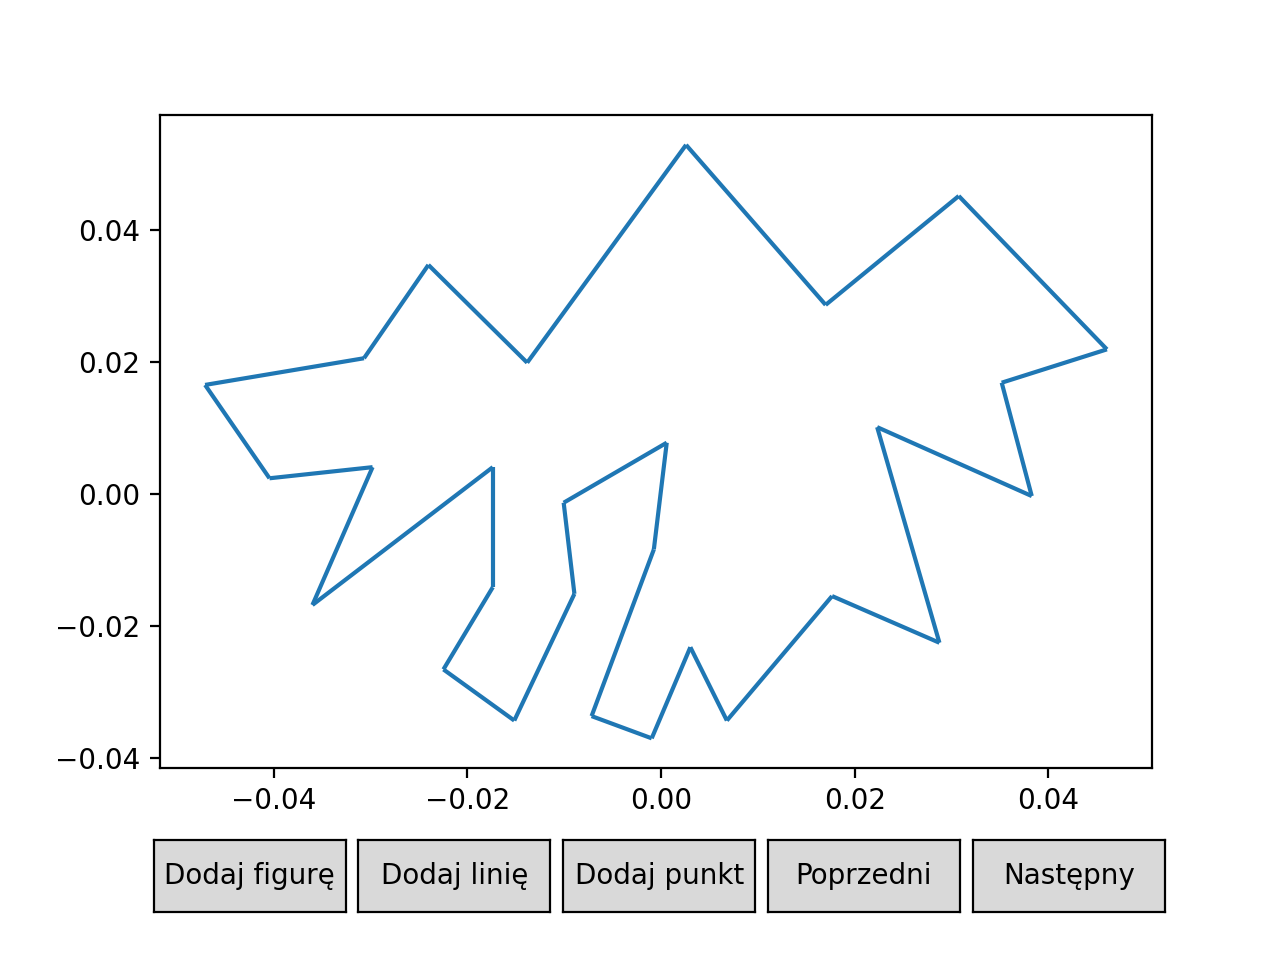

False

In [29]:
points5 = get_points(plot5)
lines5 = to_lines(points5)
Plot([Scene(lines=[LinesCollection(lines5)])]).draw()
y_monotoniczne(points5)

Zaimplementuj algorytm, który dla zadanego wielokąta będzie wyszukiwał wierzchołki początkowe, końcowe, łączące, dzielące i prawidłowe. 
Wierzchołki mają zostać odpowiednio pokolorowane zgodnie z klasyfikacją. 

In [30]:
def classify(points,epsilon = 10**-12):
    poczatkowe = []
    koncowe = []
    laczacy = []
    dzielacy = []
    prawidlowy = []
#     print(points)
    for i in range(0,len(points)-1):
        a,b,c = points[i-1],points[i],points[i+1]
        if(a[1] < b[1] > c[1]):
            if det(a,b,c) > epsilon:
                poczatkowe.append(b)
            elif det(a,b,c) < -epsilon:
                dzielacy.append(b)
        elif(a[1] > b[1] < c[1]):
            if det(a,b,c) > epsilon:
                koncowe.append(b)
            elif det(a,b,c) < -epsilon:
                laczacy.append(b)
        else:
            prawidlowy.append(b)
    a,b,c = points[len(points)-2],points[len(points)-1],points[0]
    if(a[1] < b[1] > c[1]):
        if det(a,b,c) > epsilon:
            poczatkowe.append(b)
        elif det(a,b,c) < -epsilon:
            dzielacy.append(b)
    elif(a[1] > b[1] < c[1]):
        if det(a,b,c) > epsilon:
            koncowe.append(b)
        elif det(a,b,c) < -epsilon:
            laczacy.append(b)
    else:
        prawidlowy.append(b)      
    return poczatkowe,koncowe,laczacy,dzielacy,prawidlowy


In [31]:
def draw_points(points,poczatkowe,koncowe,laczacy,dzielacy,prawidlowy):
    plot_points = Plot([Scene(lines = [LinesCollection(to_lines(points), color = "k",zorder=1)],
                points = [PointsCollection(poczatkowe,c="g",edgecolors='black',s=50,zorder=2),
                         PointsCollection(koncowe,c="r",edgecolors='black',s=50,zorder=2),
                         PointsCollection(laczacy,c="b",edgecolors='black',s=50,zorder=2),
                         PointsCollection(dzielacy,c="lightblue",edgecolors='black',s=50,zorder=2),
                         PointsCollection(prawidlowy,c="saddlebrown",edgecolors='black',s=50,zorder=2)])])
    
    plot_points.draw()

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


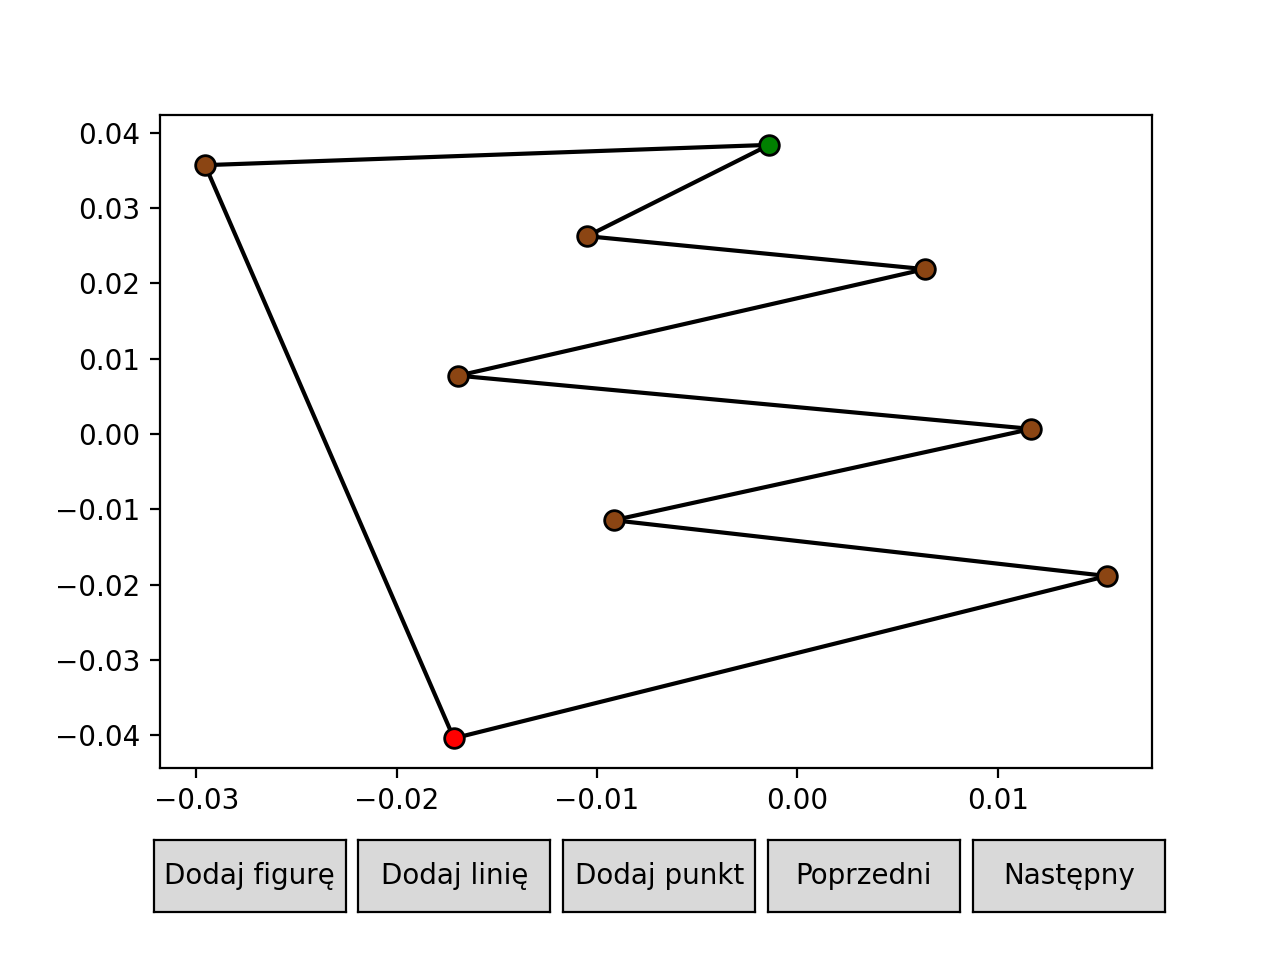

In [32]:
points = get_points(plot)
poczatkowe,koncowe,laczacy,dzielacy,prawidlowy=classify(points)
draw_points(points,poczatkowe,koncowe,laczacy,dzielacy,prawidlowy)

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


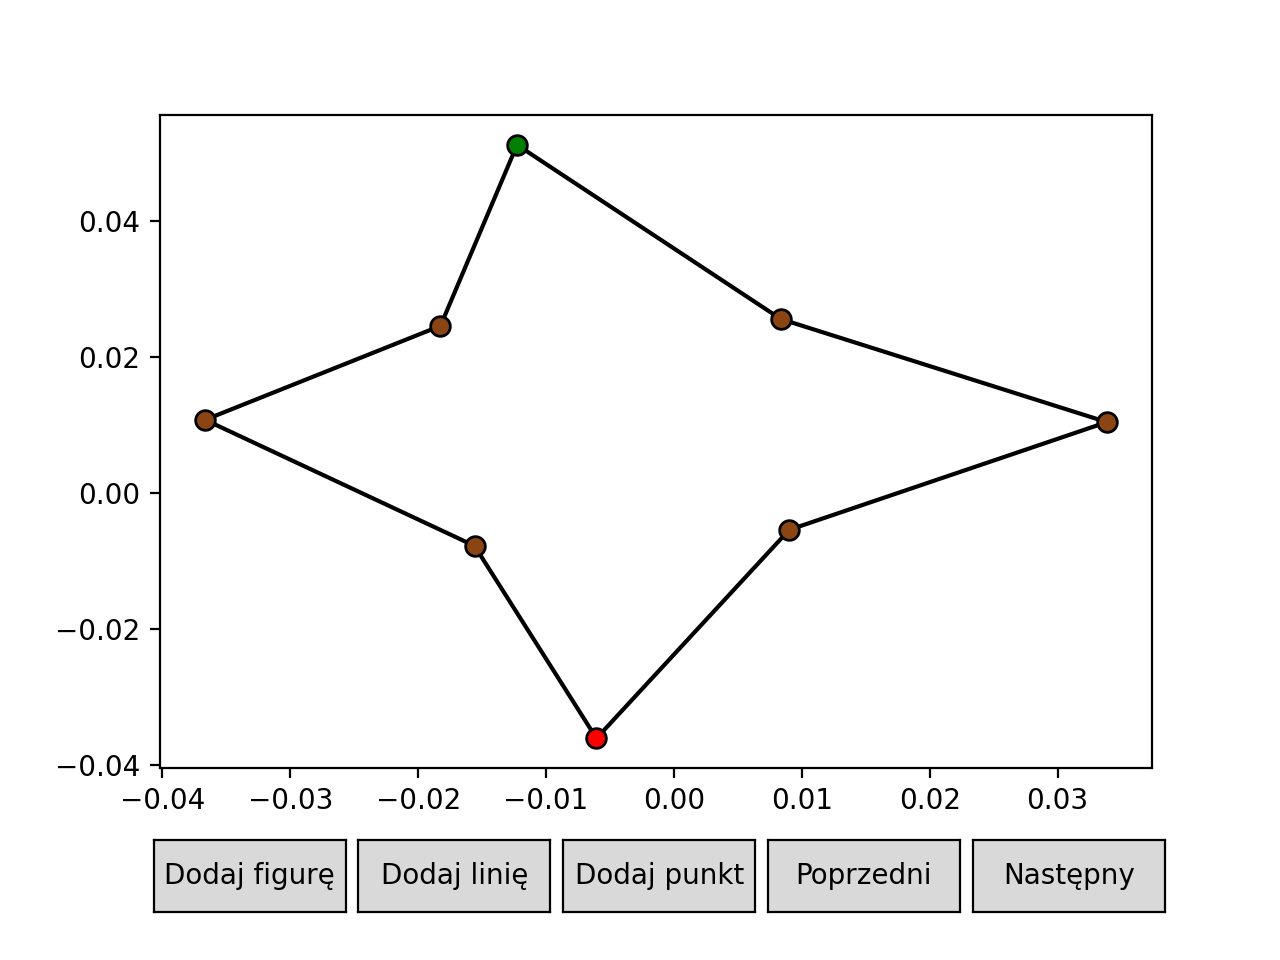

In [33]:
points2 = get_points(plot2)
poczatkowe2,koncowe2,laczacy2,dzielacy2,prawidlowy2=classify(points2)
draw_points(points2,poczatkowe2,koncowe2,laczacy2,dzielacy2,prawidlowy2)

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


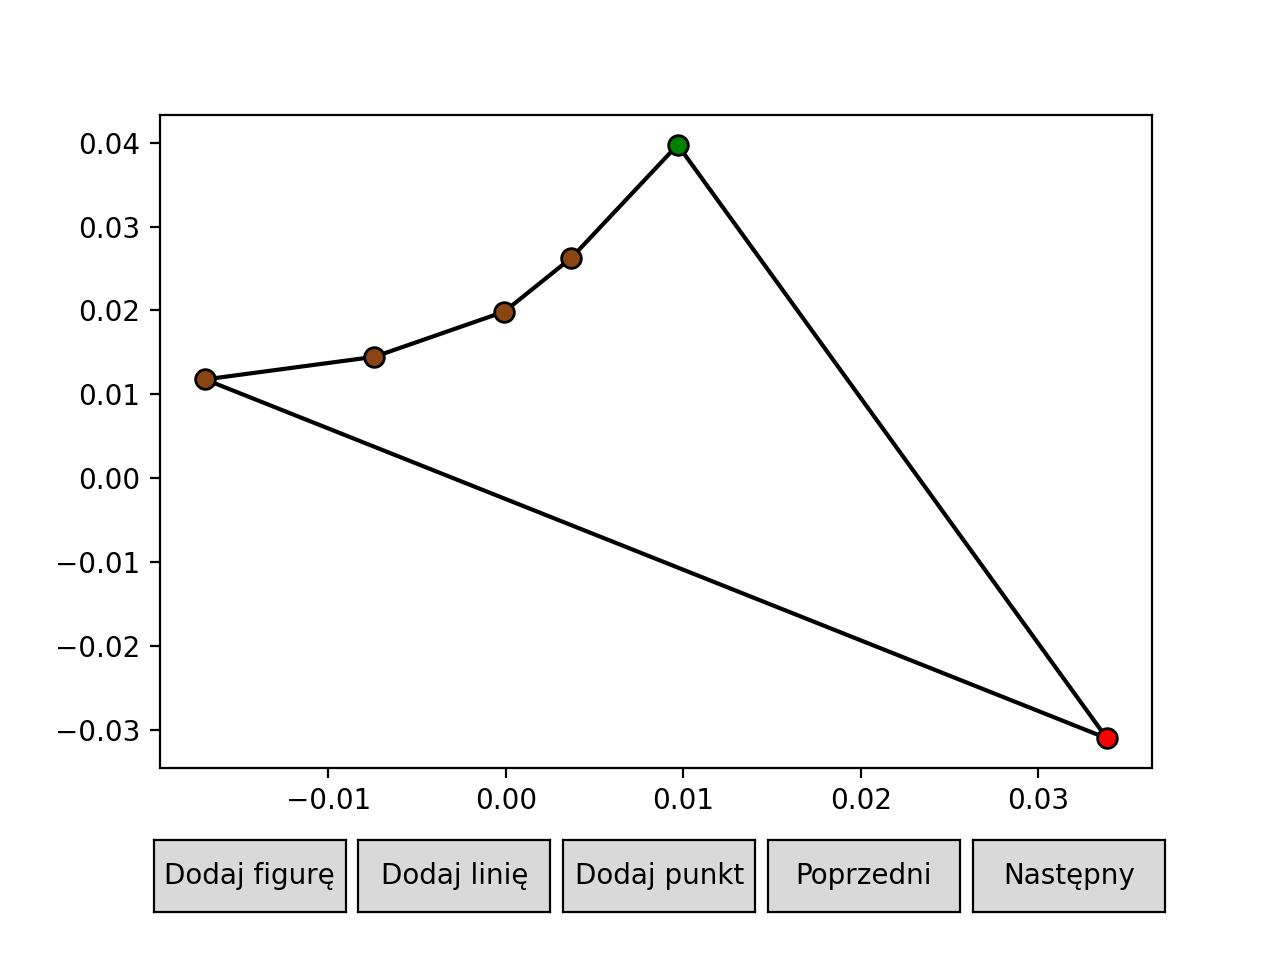

In [34]:
points3 = get_points(plot3)
poczatkowe3,koncowe3,laczacy3,dzielacy3,prawidlowy3=classify(points3)
draw_points(points3,poczatkowe3,koncowe3,laczacy3,dzielacy3,prawidlowy3)

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


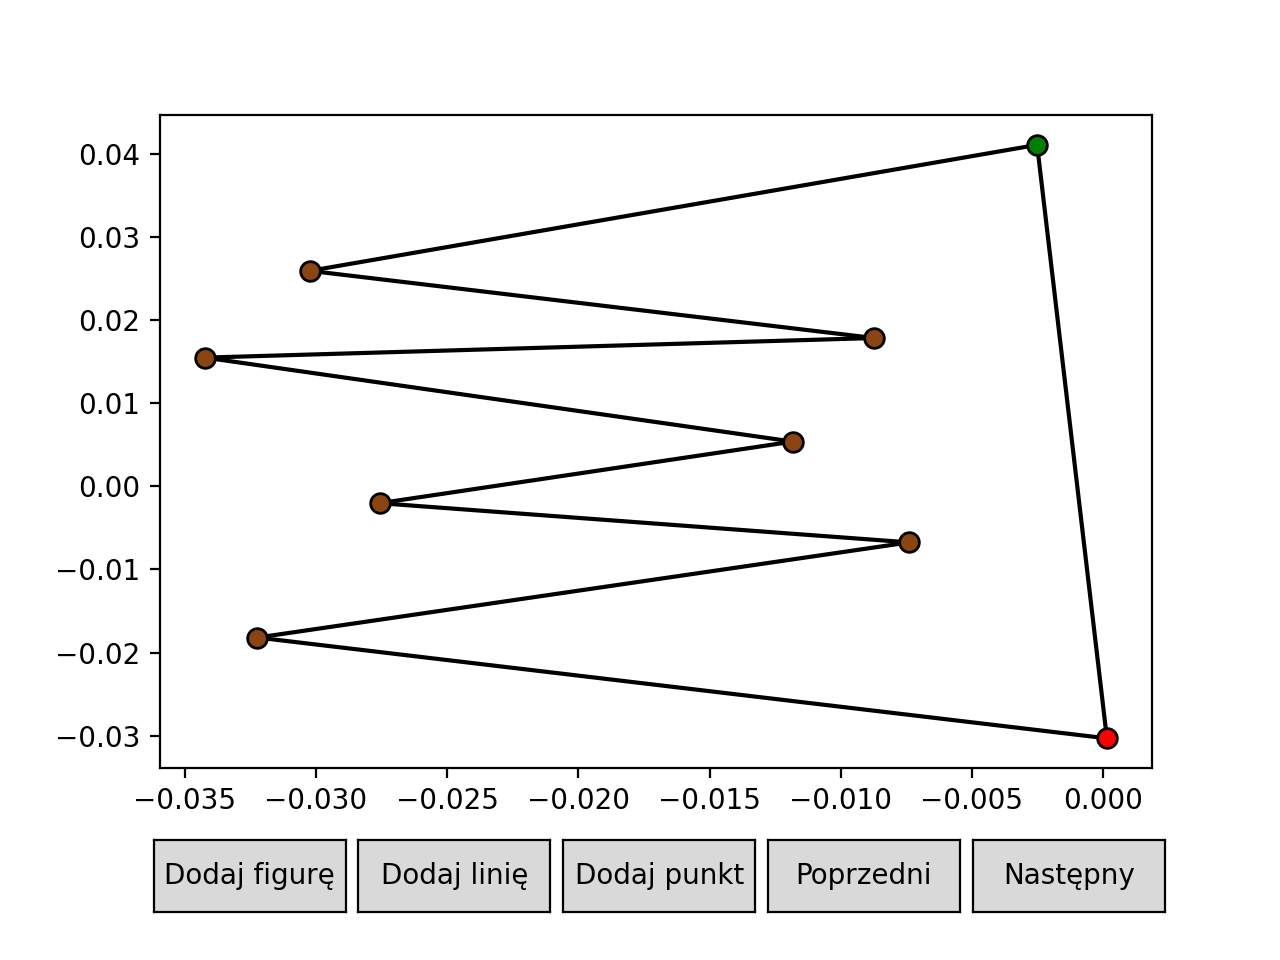

In [35]:
points4 = get_points(plot4)
poczatkowe4,koncowe4,laczacy4,dzielacy4,prawidlowy4=classify(points4)
draw_points(points4,poczatkowe4,koncowe4,laczacy4,dzielacy4,prawidlowy4)

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


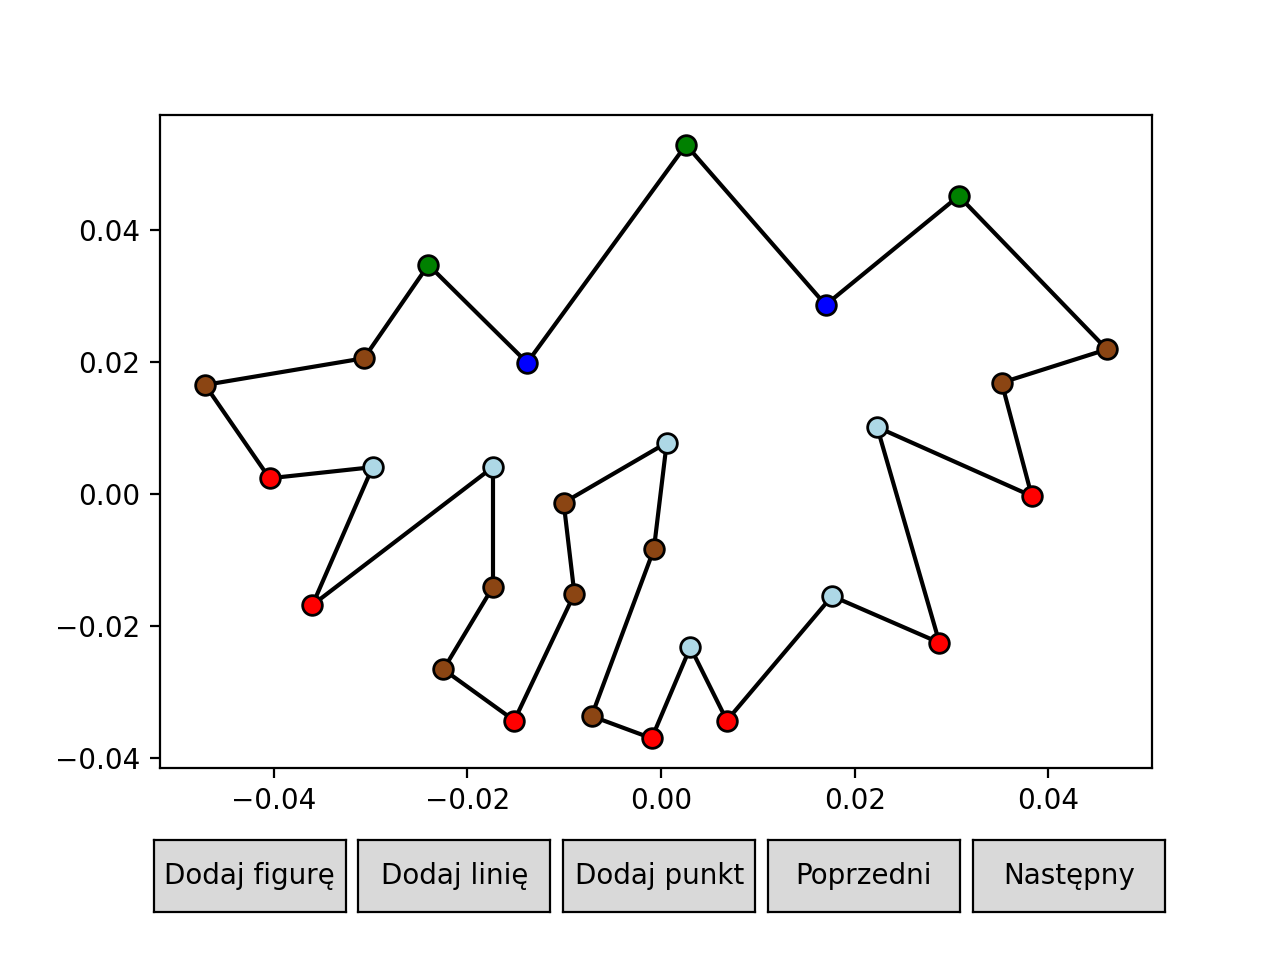

In [36]:
points5 = get_points(plot5)
poczatkowe5,koncowe5,laczacy5,dzielacy5,prawidlowy5=classify(points5)
draw_points(points5,poczatkowe5,koncowe5,laczacy5,dzielacy5,prawidlowy5)

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


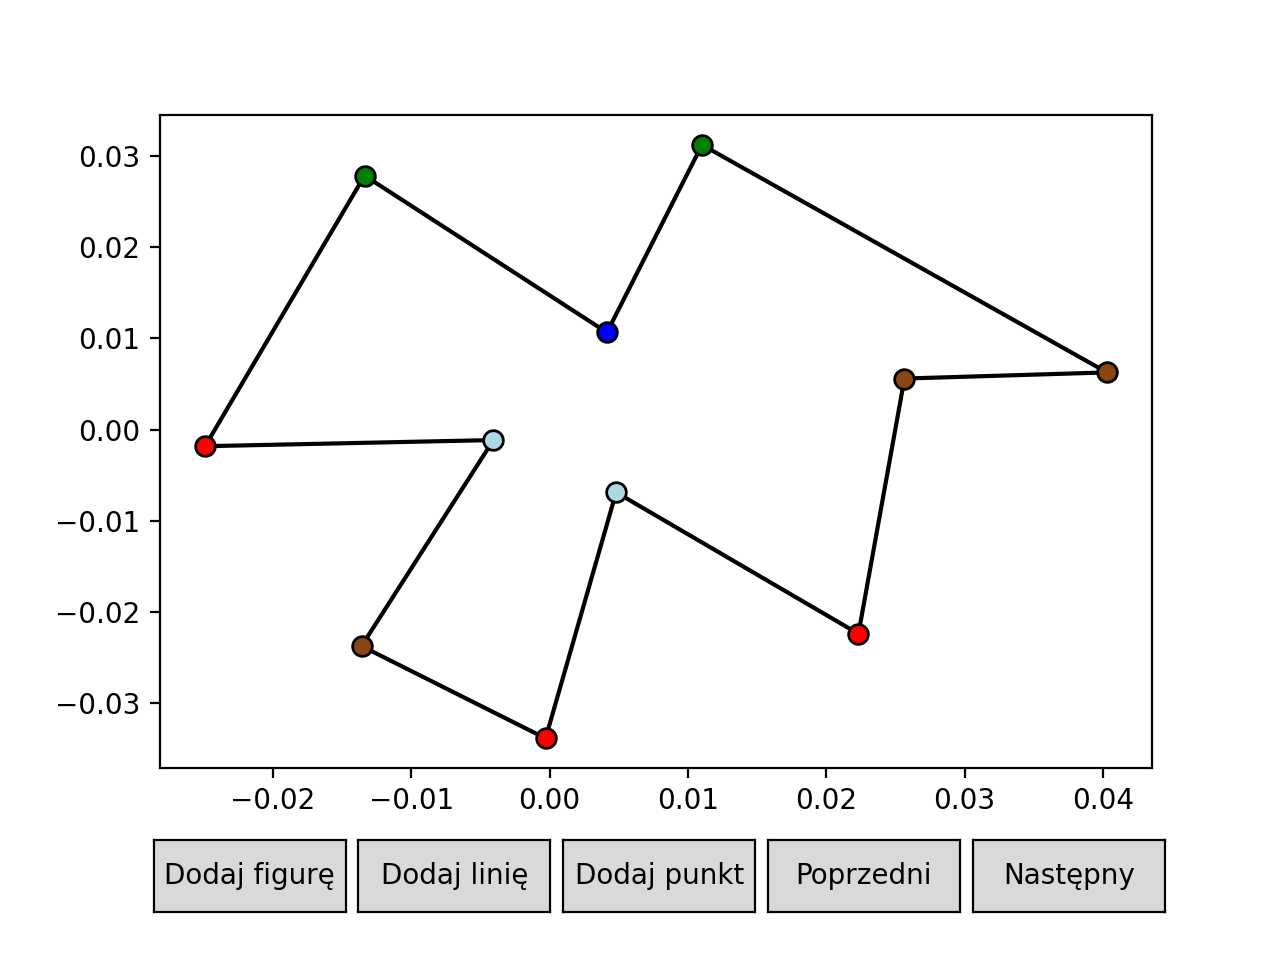

In [37]:
points6 = get_points(plot6)
poczatkowe6,koncowe6,laczacy6,dzielacy6,prawidlowy6=classify(points6)
draw_points(points6,poczatkowe6,koncowe6,laczacy6,dzielacy6,prawidlowy6)

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


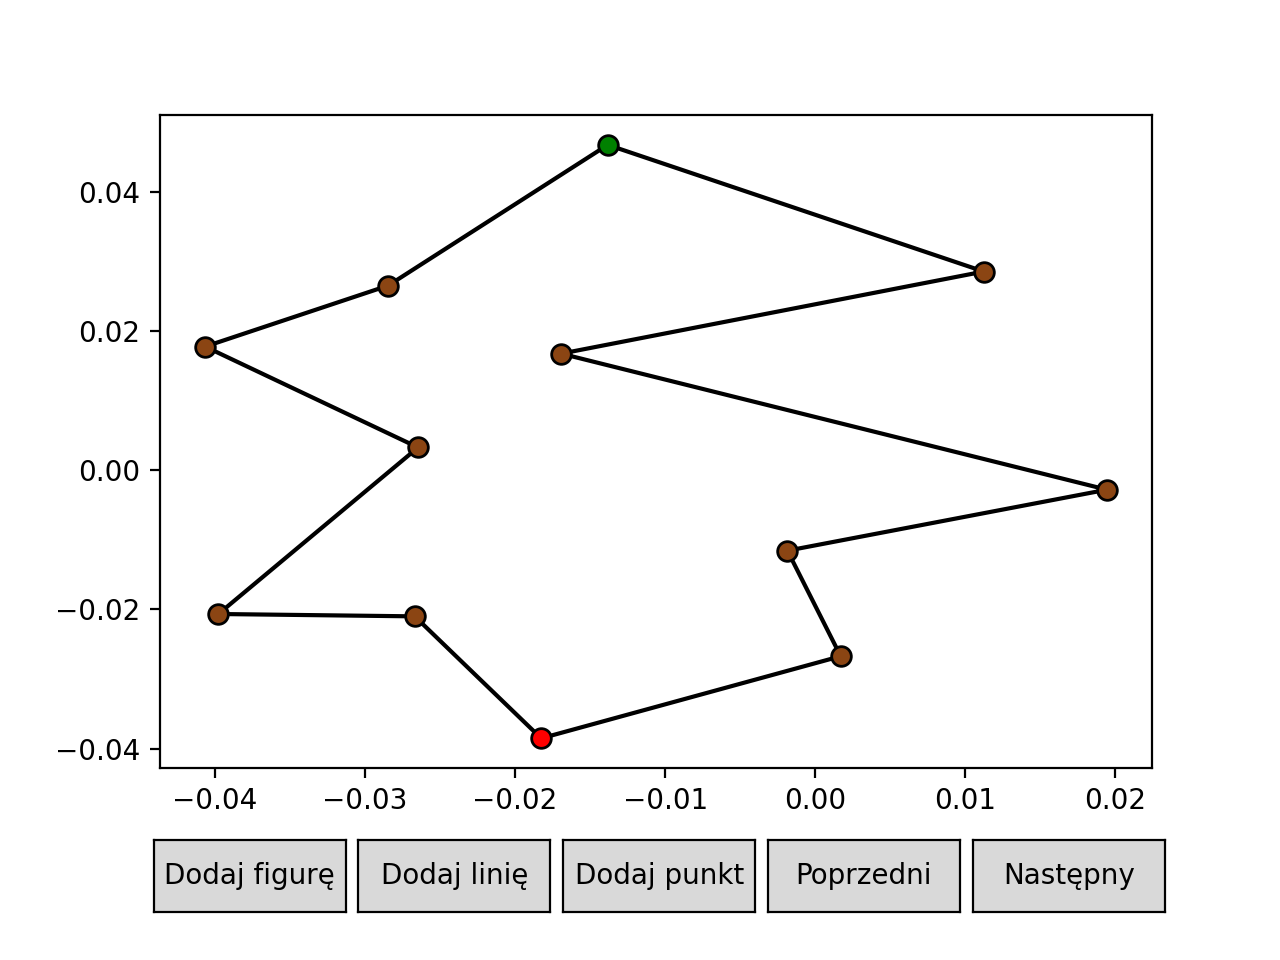

In [38]:
points7 = get_points(plot7)
poczatkowe7,koncowe7,laczacy7,dzielacy7,prawidlowy7=classify(points7)
draw_points(points7,poczatkowe7,koncowe7,laczacy7,dzielacy7,prawidlowy7)

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


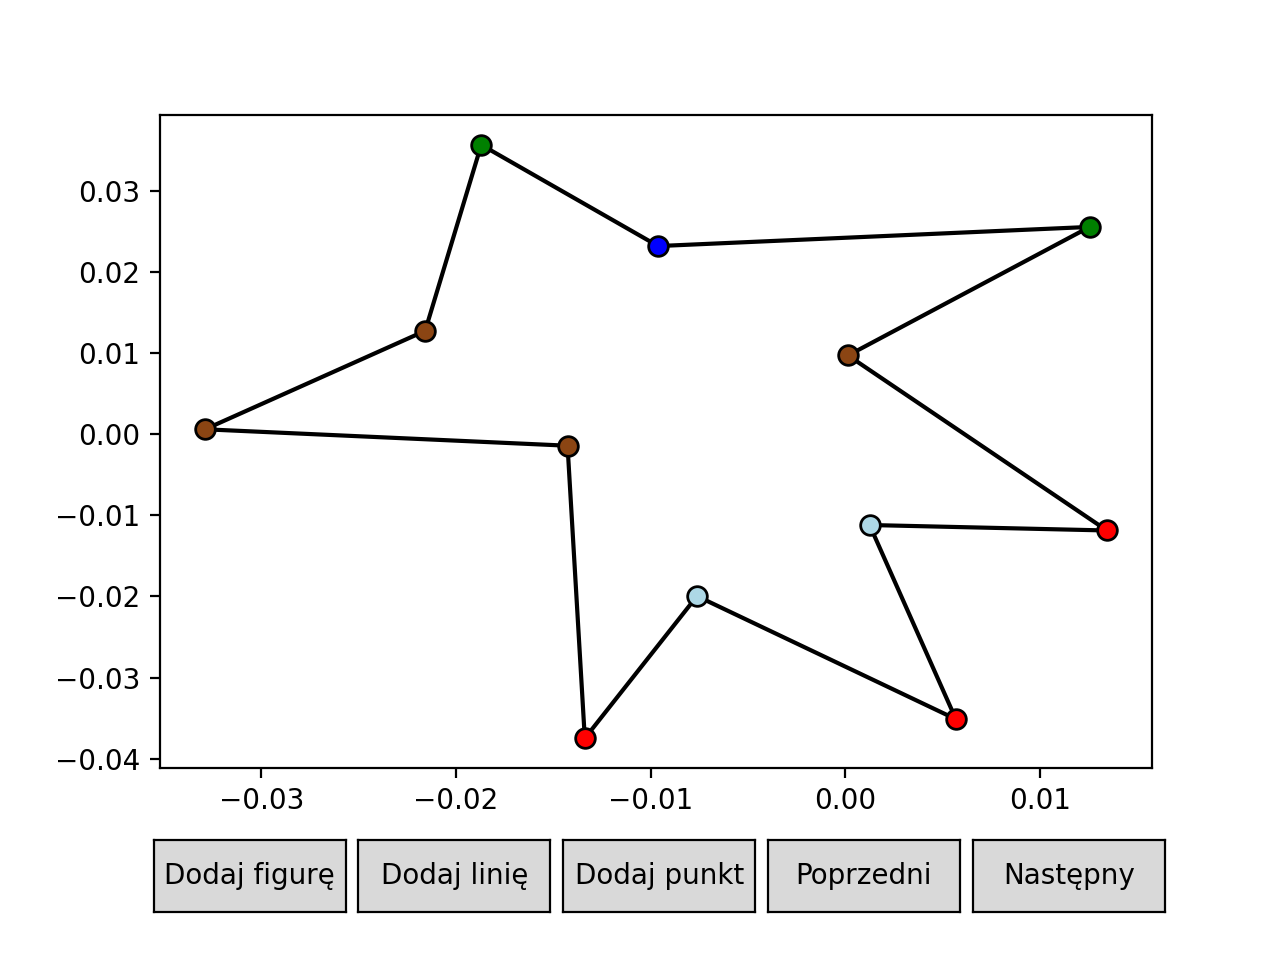

In [39]:
points8 = get_points(plot8)
poczatkowe8,koncowe8,laczacy8,dzielacy8,prawidlowy8=classify(points8)
draw_points(points8,poczatkowe8,koncowe8,laczacy8,dzielacy8,prawidlowy8)

## Triangulacja

Zaimplementuj procedurę triangulacji wielokąta monotonicznego 
(zgodnie z algorytmem opisanym na wykładzie). 
Program powinien pokazywać kolejne kroki algorytmu (tzn. kolejne tworzone trójkąty). 

In [42]:
def chains(points):
    max_len = len(points)
    left_chain = set()
    right_chain = set()
    max_index = points.index(max(points,key = lambda x: x[1]))
    min_index = points.index(min(points,key = lambda x: x[1])) 
    iterator = min_index
    while iterator != max_index:
        right_chain.add(points[iterator])
        iterator = (iterator+1) % max_len
    while iterator != min_index:
        left_chain.add(points[iterator])
        iterator = (iterator+1) % max_len
    return left_chain,right_chain
def check_chains(left_chain,right_chain,p1,p2):
    return (p1 in left_chain and p2 in left_chain ) or (p1 in right_chain and p2 in right_chain)

In [43]:
def somsiad(points,p1,p2):
    n = len(points) - 1
    index1 = points.index(p1)
    index2 = points.index(p2)
    if index1 + 1 == index2 or index2 + 1 == index1:
        return True
    if(index1 == n and index2 == 0) or (index1 == 0 and index2 == n):
        return True
    return False
def triangle(chain, a, b, c, epsilon=10 ** (-12)):
    wyz = det(a,b,c)
    if b in chain:
        if wyz < -epsilon:
            return True
        else: 
            return False
    else:
        if wyz > epsilon:
            return True
        else:
            return False

In [67]:
def triangulation(points,save = False):
    if not y_monotoniczne(points):
        print("Nie monotoniczne!")
        return [],[]
    print("Monotoniczne")
    points_index = [[i,points[i]] for i in range(len(points))]
    lines = to_lines(points)
    scenes = [Scene(points = [PointsCollection(points, color="green",edgecolors='black',s=50,zorder=2)],
                   lines = [LinesCollection(lines, color="black",zorder=1)])]
    left,right = chains(points)
    points_index.sort(key = lambda x: x[1][1], reverse = True)
    stos = [points_index[0][1],points_index[1][1]]
    stos_save = [points_index[0],points_index[1]]
    przekatne = []
    przekatne_save = []
    for i in range(2,len(points)):
        scenes.append(Scene(points=[PointsCollection(points, color="green",edgecolors='black',s=50,zorder=2),
                                    PointsCollection([*stos], color="red",edgecolors='black',s=50,zorder=2),
                                    PointsCollection([points_index[i][1]], color="yellow",edgecolors='black',s=50,zorder=2)],
                            lines=[LinesCollection(lines, color="black",zorder=1),
                                   LinesCollection([*przekatne], color="blue",zorder=1)]))
        if check_chains(left,right,stos[-1],points_index[i][1]):
            point = stos.pop()
            point_save = stos_save.pop()
            while len(stos) > 0 and triangle(right,stos[-1],point,points_index[i][1]):
                if not somsiad(points, point, points_index[i][1]):
                    if [point,points_index[i][1]] not in przekatne:
                        przekatne.append([point,points_index[i][1]])
                        przekatne_save.append([point_save,points_index[i]])
                if not somsiad(points, stos[-1], points_index[i][1]):
                    if [stos[-1],points_index[i][1]] not in przekatne:
                        przekatne.append([stos[-1],points_index[i][1]])
                        przekatne_save.append([stos_save[-1],points_index[i]])
                point = stos.pop()
                point_save = stos_save.pop()
                scenes.append(Scene(points=[PointsCollection(points, color="green",edgecolors='black',s=50,zorder=2),
                                PointsCollection([*stos], color="red",edgecolors='black',s=50,zorder=2),
                                PointsCollection([points_index[i][1]], color="yellow",edgecolors='black',s=50,zorder=2),
                                PointsCollection([point], color="purple",edgecolors='black',s=50,zorder=2)],
                        lines=[LinesCollection(lines, color="black",zorder=1),
                               LinesCollection([*przekatne], color="blue",zorder=1)]))    
            stos.append(point)
            stos.append(points_index[i][1])
            stos_save.append(point_save)
            stos_save.append(points_index[i])
        else:
            while len(stos) > 0:
                point = stos.pop()
                point_save = stos_save.pop()
                if not somsiad(points,point,points_index[i][1]):
                    przekatne.append([point,points_index[i][1]])
                    przekatne_save.append([point_save,points_index[i]])
                scenes.append(Scene(points=[PointsCollection(points, color="green",edgecolors='black',s=50,zorder=2),
                                PointsCollection([*stos], color="red",edgecolors='black',s=50,zorder=2),
                                PointsCollection([points_index[i][1]], color="yellow",edgecolors='black',s=50,zorder=2),
                                PointsCollection([point], color="purple",edgecolors='black',s=50,zorder=2)],
                        lines=[LinesCollection(lines, color="black",zorder=1),
                               LinesCollection([*przekatne], color="blue",zorder=1)]))
            stos.append(points_index[i-1][1])
            stos.append(points_index[i][1])
            stos_save.append(points_index[i-1])
            stos_save.append(points_index[i])
    scenes.append(Scene(points = [PointsCollection(points, color="green",edgecolors='black',s=50,zorder=2)],
                   lines = [LinesCollection(lines, color="black",zorder=1),
                           LinesCollection([*przekatne], color="blue",zorder=1)]))
    if save:
        with open('somefile.json', 'w') as file:
            for l in przekatne_save:
                file.write(str(l)+"\n")
    return przekatne,scenes

Monotoniczne
Przekątne: 6


/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


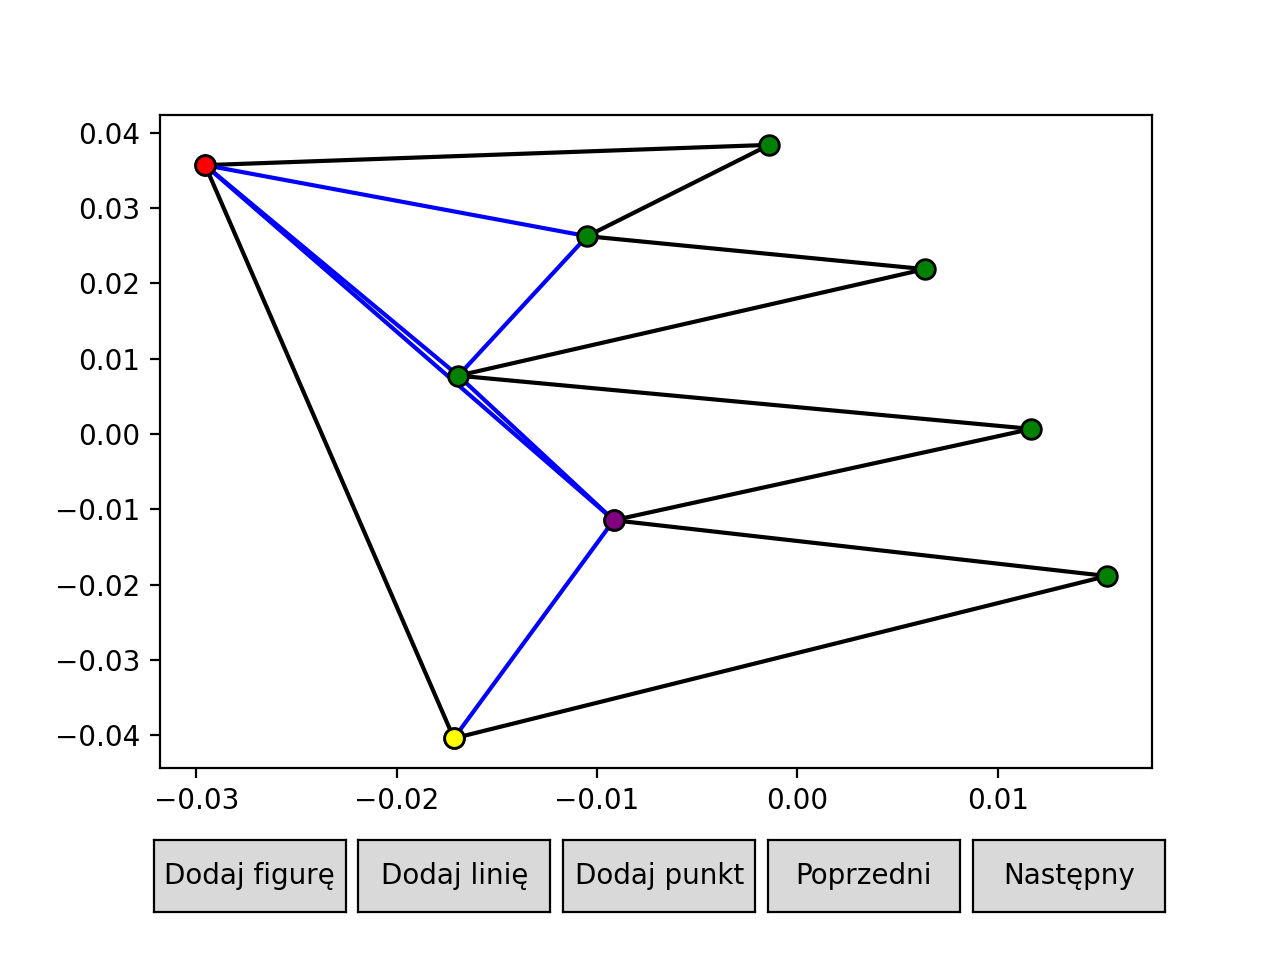

In [48]:
przekatne,scenes = triangulation(points)
if(len(przekatne) > 0):
    print("Przekątne:",len(przekatne))
    triangle_plot = Plot(scenes)
    triangle_plot.draw()

Monotoniczne
Przekątne: 5


/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


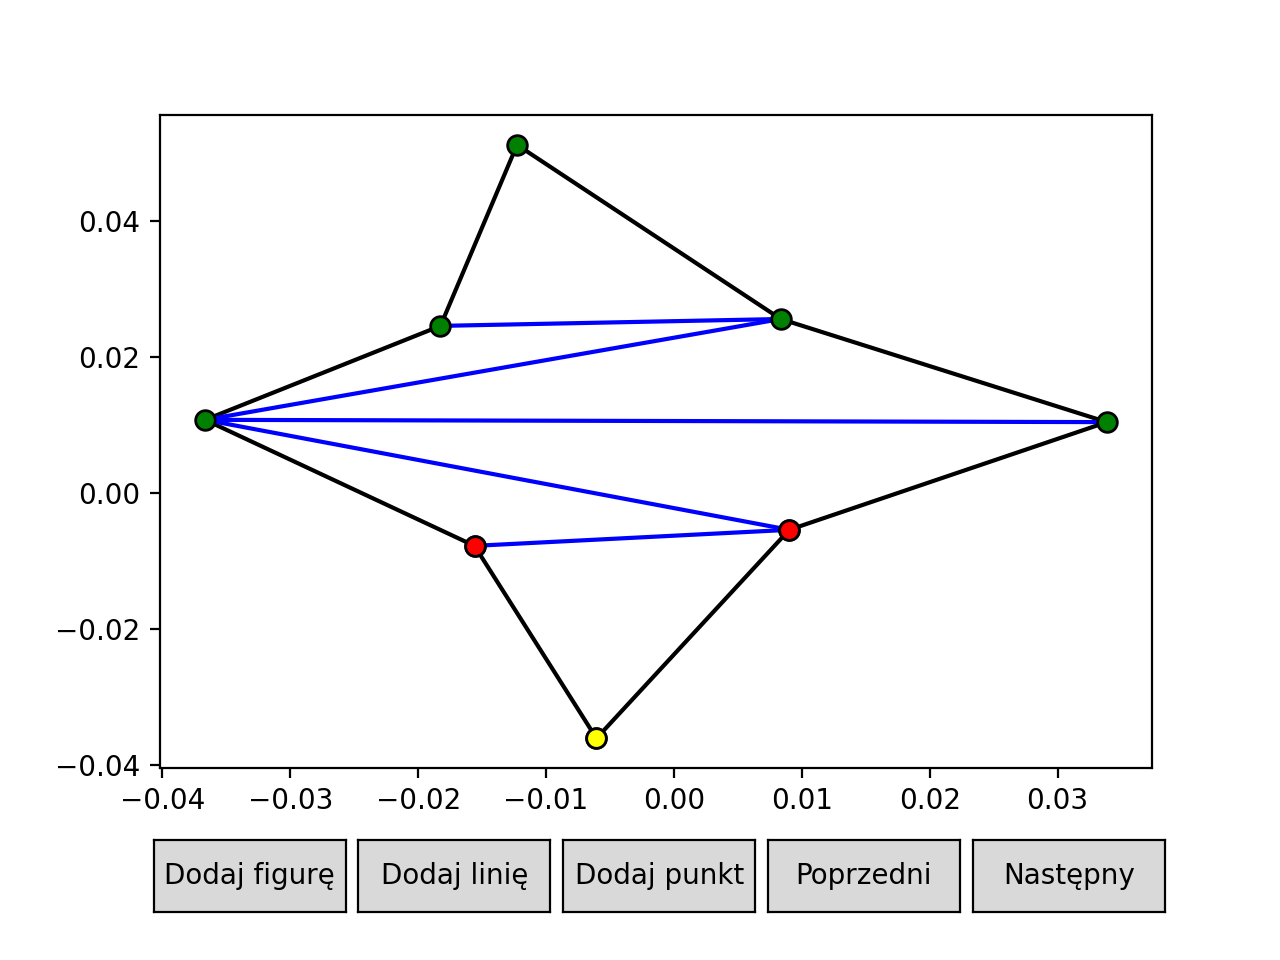

In [49]:
przekatne2,scenes2 = triangulation(points2)
if(len(przekatne2) > 0):
    print("Przekątne:",len(przekatne2))
    triangle_plot = Plot(scenes2)
    triangle_plot.draw()

Monotoniczne
Przekątne: 3


<IPython.core.display.Javascript object>


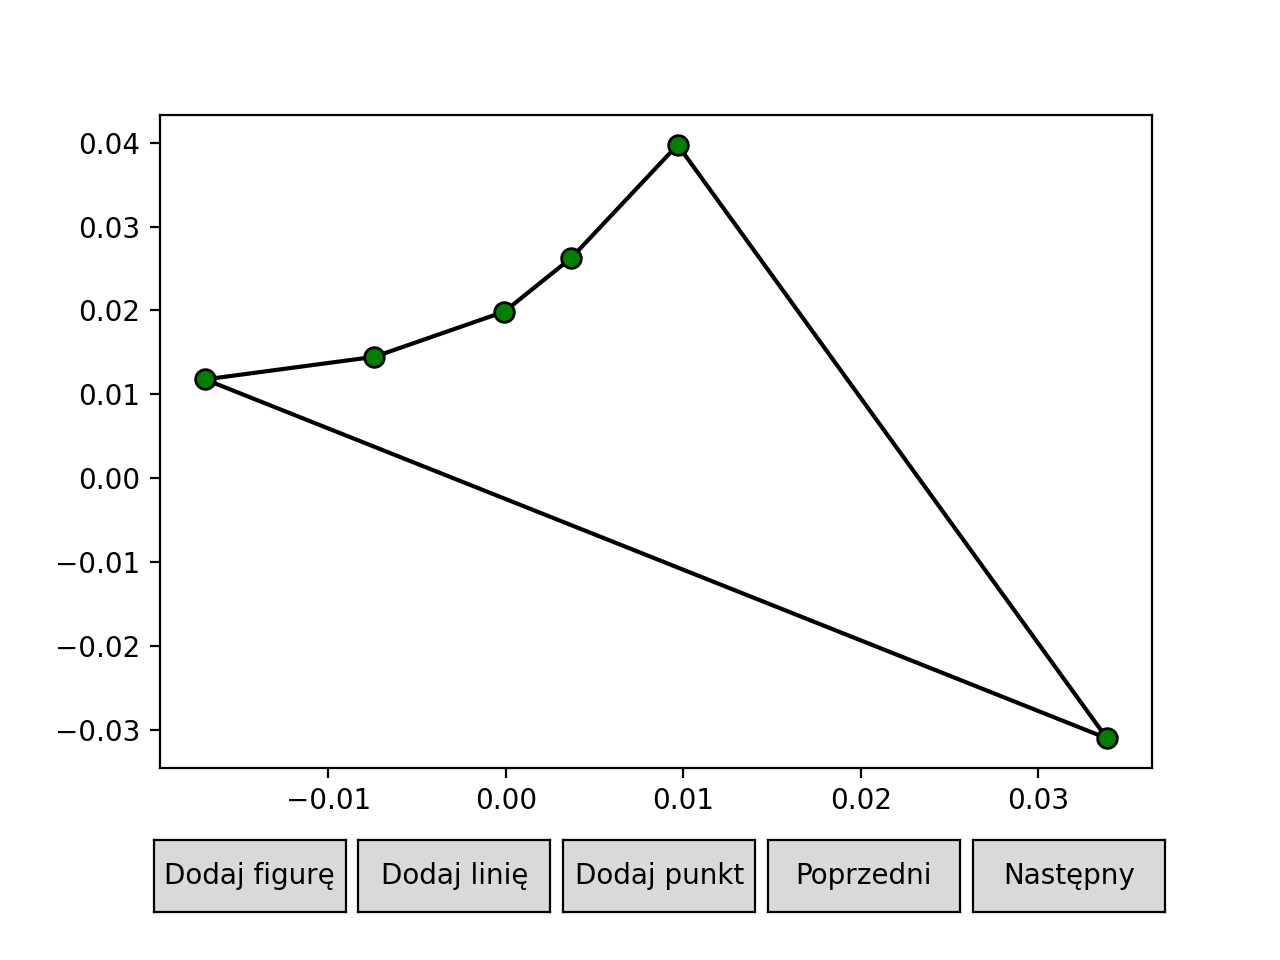

In [74]:
przekatne3,scenes3 = triangulation(points3)
if(len(przekatne3) > 0):
    print("Przekątne:",len(przekatne3))
    triangle_plot = Plot(scenes3)
    triangle_plot.draw()

Monotoniczne
Przekątne: 6


/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


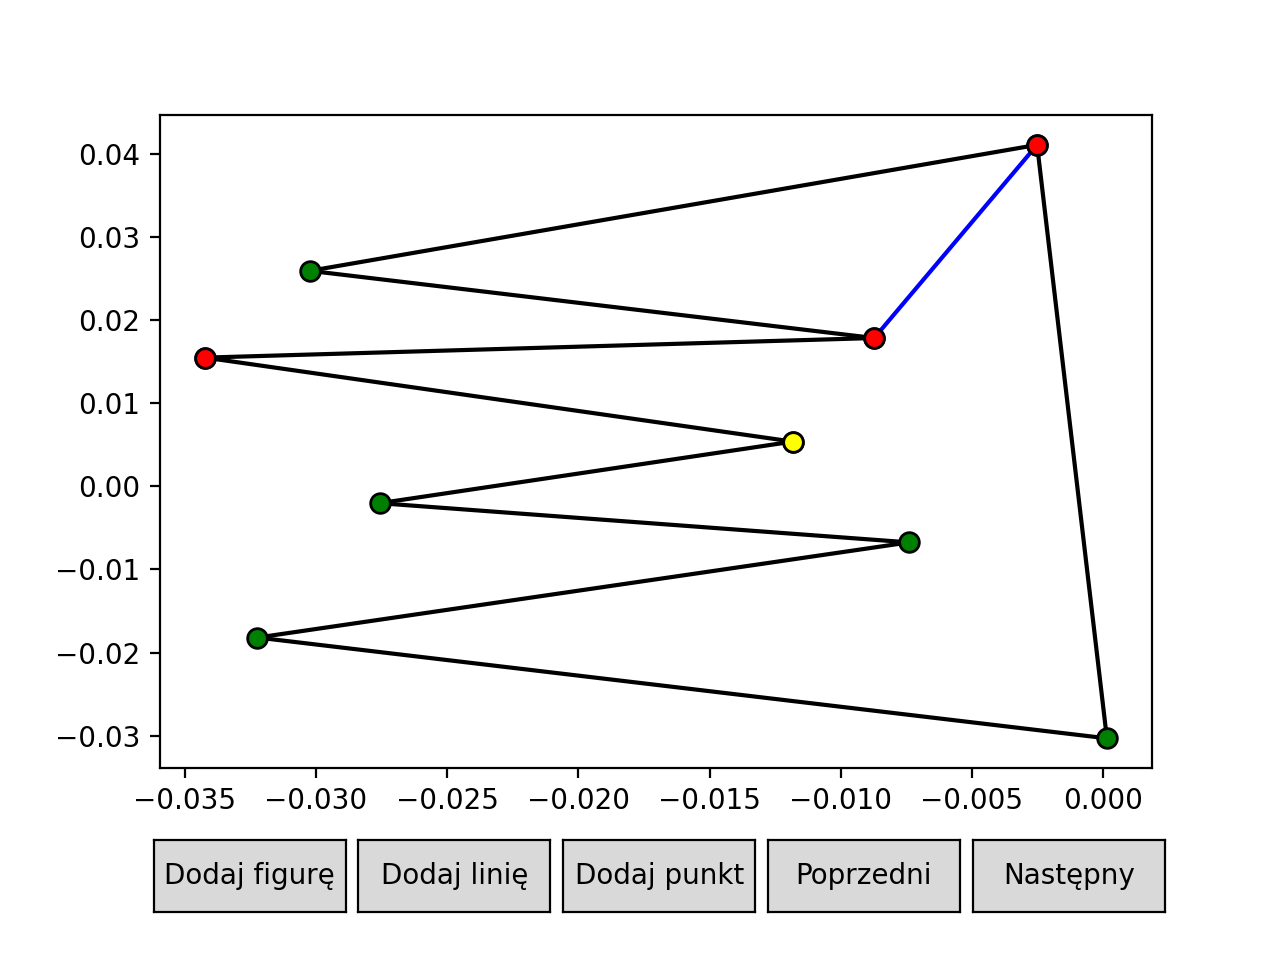

In [75]:
przekatne4,scenes4 = triangulation(points4)
if(len(przekatne4) > 0):
    print("Przekątne:",len(przekatne4))
    triangle_plot = Plot(scenes4)
    triangle_plot.draw()

In [52]:
przekatne5,scenes5 = triangulation(points5)
if(len(przekatne5) > 0):
    print("Przekątne:",len(przekatne5))
    triangle_plot = Plot(scenes5)
    triangle_plot.draw()

Nie monotoniczne!


In [53]:
przekatne6,scenes6 = triangulation(points6)
if(len(przekatne6) > 0):
    print("Przekątne:",len(przekatne6))
    triangle_plot = Plot(scenes6)
    triangle_plot.draw()

Nie monotoniczne!


Monotoniczne
Przekątne: 9


/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


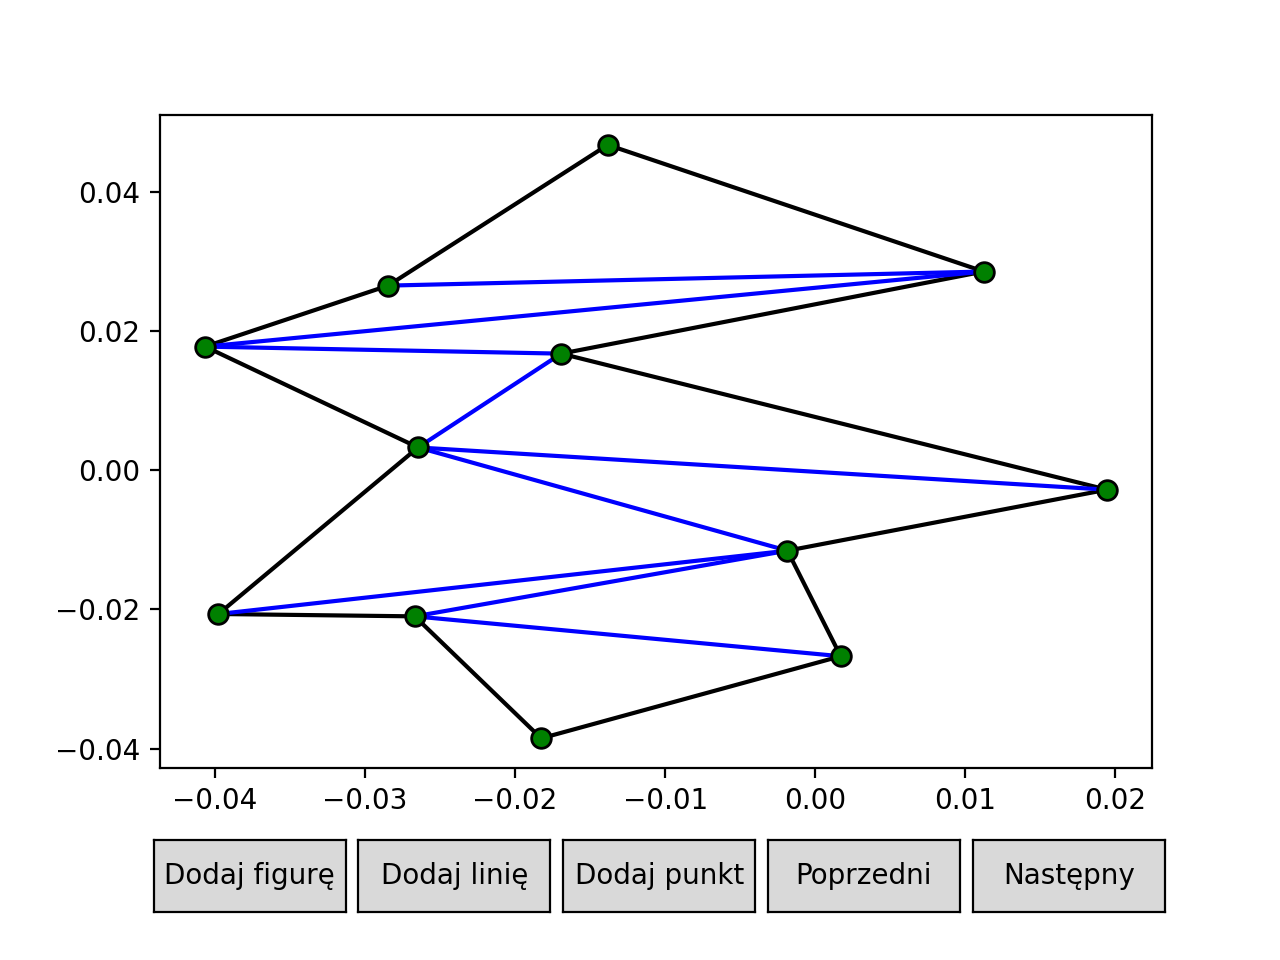

In [54]:
przekatne7,scenes7 = triangulation(points7)
if(len(przekatne7) > 0):
    print("Przekątne:",len(przekatne7))
    triangle_plot = Plot(scenes7)
    triangle_plot.draw()

In [55]:
przekatne8,scenes8 = triangulation(points8)
if(len(przekatne8) > 0):
    print("Przekątne:",len(przekatne8))
    triangle_plot = Plot(scenes8)
    triangle_plot.draw()

Nie monotoniczne!


/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


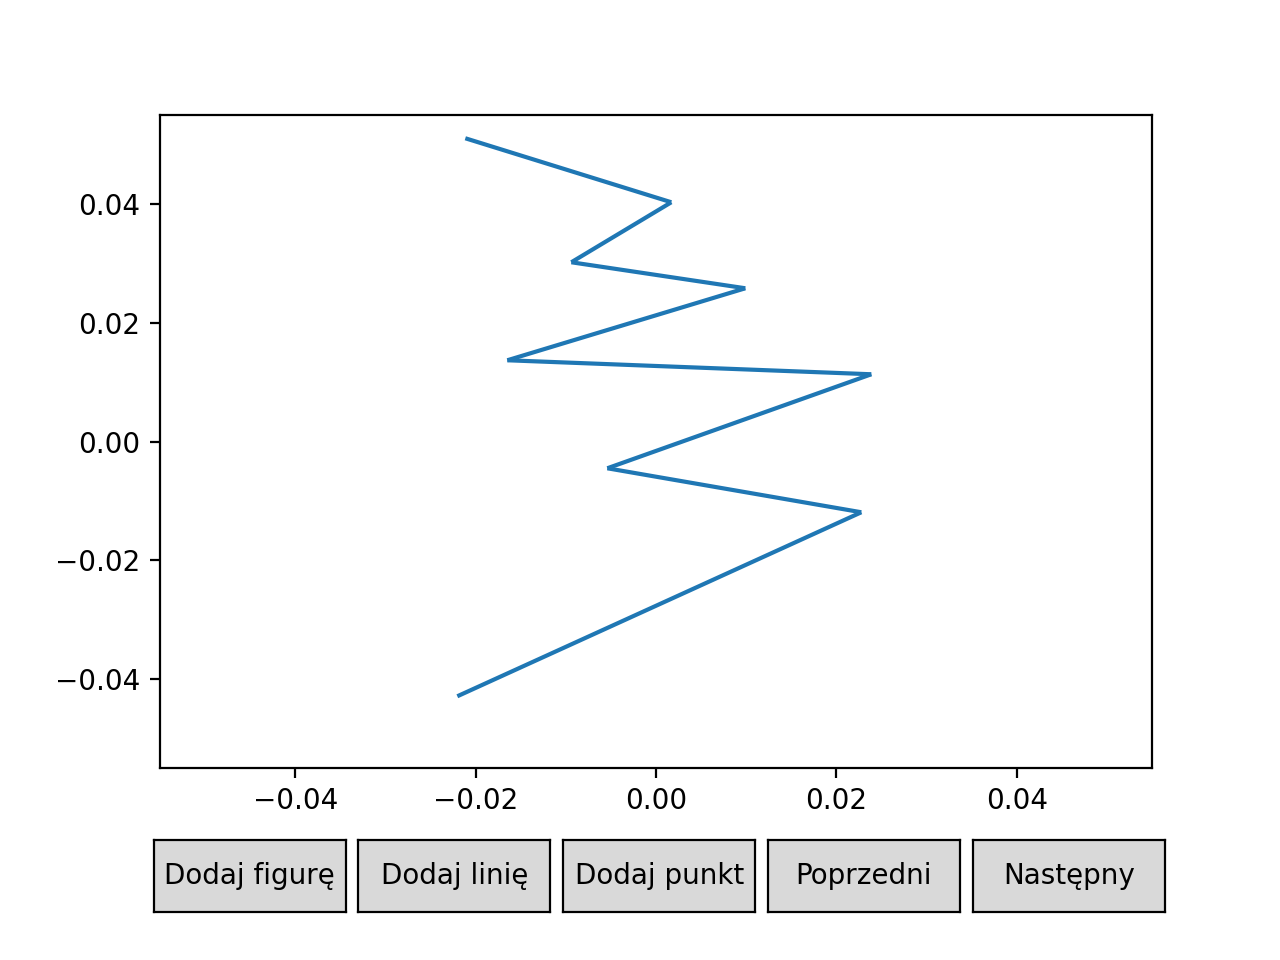

In [69]:
plot10 = Plot([Scene()])
plot10.draw()

Monotoniczne
Przekątne: 6


/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_17388/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


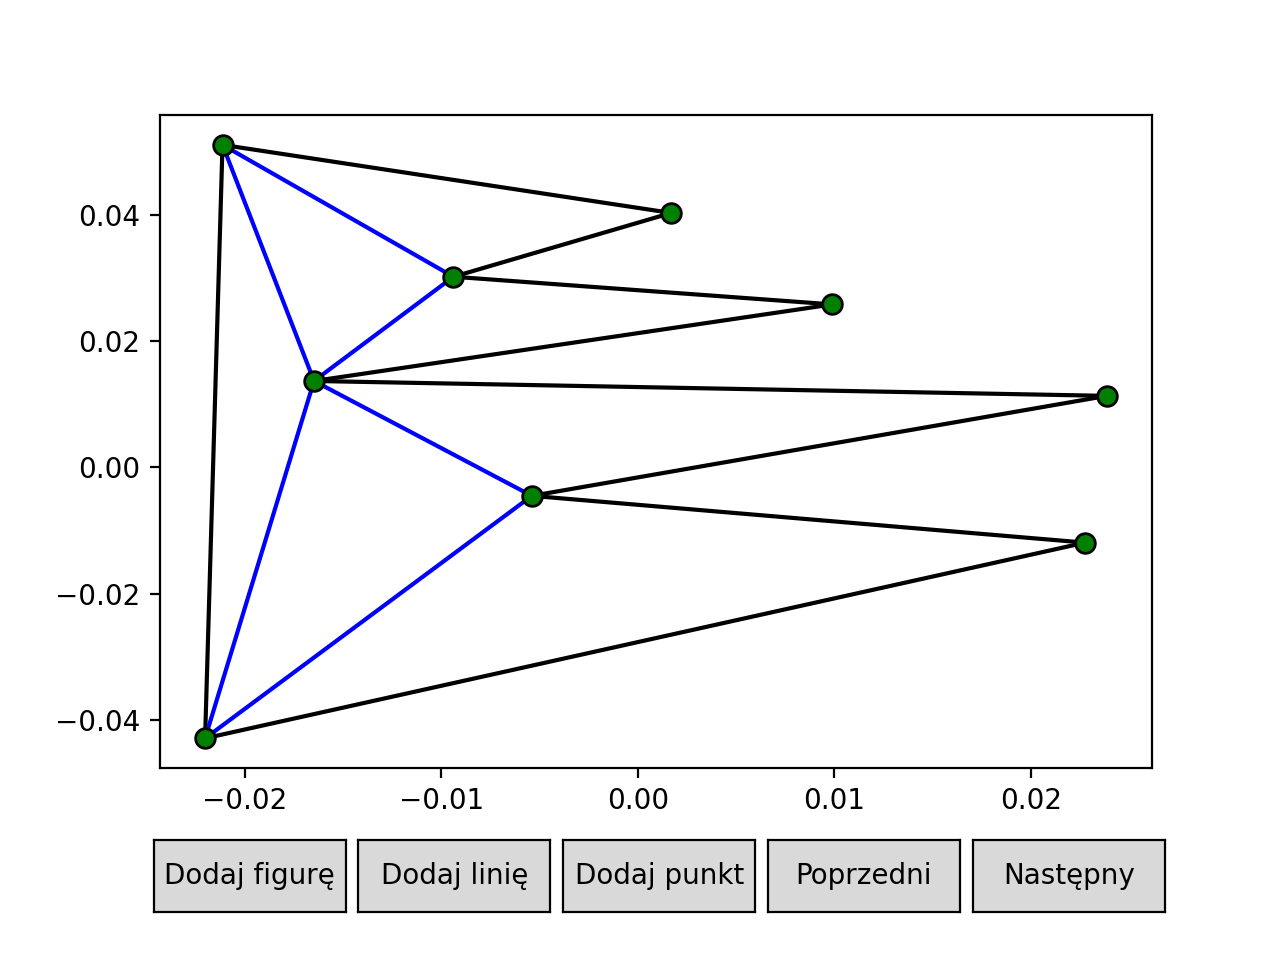

In [76]:
points10 = get_points(plot10)
przekatne10,scenes10 = triangulation(points10)
if(len(przekatne10) > 0):
    print("Przekątne:",len(przekatne10))
    triangle_plot = Plot(scenes10)
    triangle_plot.draw()